In [1]:
import os
import signal
import sys
import pandas as pd
from timeout_decorator import TimeoutError
import tempfile
from matplotlib import pyplot as plt
from rdkit.Chem.Draw import rdMolDraw2D
from itertools import permutations
from rdkit import Chem
import numpy as np
import cv2
sys.path.append(os.path.abspath('..'))

import os
import sys
import torch

from typing import List
from pandarallel import pandarallel
import yaml
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from rdkit import Chem
from models.model_layer import BOS
from models.utils import caonicalize_rxn_smiles, get_dummy_atom_masks, identify_attention_token_idx_for_rxn_component, inference_load

from models.parrot_model import ParrotConditionPredictionModel


In [2]:
class ParrotConditionPredictionModelAnalysis(ParrotConditionPredictionModel):

    def __init__(self,
                 model_type,
                 model_name,
                 tokenizer_type=None,
                 tokenizer_name=None,
                 weight=None,
                 args=None,
                 use_cuda=True,
                 cuda_device=-1,
                 freeze_encoder=False,
                 freeze_all_but_one=False,
                 **kwargs):
        super().__init__(model_type, model_name, tokenizer_type,
                         tokenizer_name, weight, args, use_cuda, cuda_device,
                         freeze_encoder, freeze_all_but_one, **kwargs)

    def generate_condition2condition_attn(
        self,
        rxn_smiles: List,
        ground_truth: List = [],
        batch_size=8,
        normalize_react_and_prod=True,
        dataset_flag: str = 'val',
        evaluate_mode: bool = False,
    ):
        condition_type_maping = {'c1': 0, 's1': 1, 's2': 2, 'r1': 3, 'r2': 4}

        input_df_with_fake_labels = pd.DataFrame({
            'text':
            rxn_smiles,
            'labels': [[0] * 7] * len(rxn_smiles)
        })

        prediction_catch_dir = os.path.join(os.getcwd(), '.catch')
        catch_file_path = os.path.join(
            prediction_catch_dir,
            f'c2c_cached_prediction_results_{dataset_flag}_cnt_{len(input_df_with_fake_labels)}.pkl'
        )
        os.makedirs(prediction_catch_dir, exist_ok=True)

        if not os.path.exists(catch_file_path):

            predicted_conditions, attention_weights, input_tokens = self.greedy_search_batch_with_attn(
                input_df_with_fake_labels,
                test_batch_size=batch_size,
                normalize=True,
                transpose_end=False)
            self_attention_weights = attention_weights['decoder_self_attn']
            input_df_with_fake_labels[
                'predicted_conditions'] = predicted_conditions
            input_df_with_fake_labels[
                'attention_weights'] = self_attention_weights
            input_df_with_fake_labels['input_tokens'] = input_tokens
            input_df_with_fake_labels.to_pickle(catch_file_path)
        else:
            input_df_with_fake_labels = pd.read_pickle(catch_file_path)
            predicted_conditions, self_attention_weights, input_tokens = input_df_with_fake_labels[
                'predicted_conditions'].tolist(
                ), input_df_with_fake_labels['attention_weights'].tolist(
                ), input_df_with_fake_labels['input_tokens'].tolist()
            
            pass

        return predicted_conditions, self_attention_weights, input_tokens


In [3]:
def init_data_and_model(
    num_workers=10,
    gpu=0,
    config_path='../configs/config_inference_use_uspto.yaml',
    input_path='../dataset/source_dataset/USPTO_condition_final/USPTO_condition_pred_category_maped_rxn_tpl.csv',
    dataset_flag='val',
    debug=True,
    reaction_class='Suzuki coupling',
):
    pandarallel.initialize(nb_workers=num_workers, progress_bar=True)
    config = yaml.load(open(config_path, "r"), Loader=yaml.FullLoader)

    print(
        '\n########################\Attention Evaluation configs:\n########################\n'
    )
    print(yaml.dump(config))
    print('\n########################\n')
    model_args = config['model_args']
    model_args['pretrained_path'] = os.path.join('..',
                                                 model_args['pretrained_path'])
    model_args['output_dir'] = os.path.join('..', model_args['output_dir'])
    model_args['best_model_dir'] = os.path.join('..',
                                                model_args['best_model_dir'])
    model_args['output_attention'] = model_args.get('output_attention', True)
    model_args['silent'] = True

    dataset_args = config['dataset_args']
    dataset_args['dataset_root'] = os.path.join('..',
                                                dataset_args['dataset_root'])

    try:
        model_args['use_temperature'] = dataset_args['use_temperature']
        print('\nUsing Temperature:', model_args['use_temperature'])
    except:
        print('\nNo temperature information is specified!')

    condition_label_mapping = inference_load(**dataset_args)
    model_args['decoder_args'].update({
        'tgt_vocab_size':
        len(condition_label_mapping[0]),
        'condition_label_mapping':
        condition_label_mapping
    })

    trained_path = model_args['best_model_dir']
    model: ParrotConditionPredictionModelAnalysis = ParrotConditionPredictionModelAnalysis(
        "bert",
        trained_path,
        args=model_args,
        use_cuda=True if gpu >= 0 else False,
        cuda_device=gpu)

    input_df = pd.read_csv(input_path)

    condition_type2cols = {
        'c1': 'catalyst1',
        's1': 'solvent1',
        's2': 'solvent2',
        'r1': 'reagent1',
        'r2': 'reagent2'
    }
    condition_cols = [
        'catalyst1', 'solvent1', 'solvent2', 'reagent1', 'reagent2'
    ]
    for col in condition_cols:
        input_df.loc[input_df[col].isna(), col] = ''

    input_df.loc[input_df['retro_template'].isna(), 'retro_template'] = ''
    input_df = input_df.loc[input_df['dataset'] == dataset_flag]
    input_df = input_df.loc[input_df['rxn_class_name'] == reaction_class]
    input_df = input_df.loc[input_df['retro_template'] != ''].reset_index(
        drop=True)
    if debug:
        input_df = input_df[:100]
    # input_rxn_smiles = input_df['canonical_rxn'].tolist()
    # retro_templates = input_df['retro_template'].tolist()

    input_df['ground_truth_conditions'] = input_df.parallel_apply(
        lambda row: row[condition_cols].tolist(), axis=1).tolist()
    
    return input_df, model


In [4]:
def get_results(result):
    if pd.isna(result):
        return 
    return result['mapped_rxn']
def timeout(seconds=5):
    def decorator(func):
        def wrapper(*args, **kwargs):
            def signal_handler(signum, frame):
                raise TimeoutError('Function %s timed out after %s seconds' % (func.__name__, seconds))
            signal.signal(signal.SIGALRM, signal_handler)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result
        return wrapper
    return decorator


def gen_plus(n=15, dpi=300, save_path=None):
    # 创建一个新的图形对象
    size = (300/n, 300)
    dpi = 300
    figsize = float(size[0]) / dpi, float(size[1]) / dpi
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # 绘制横线
    ax.plot([-0.05*n, 0.05*n], [0, 0], color='black', linewidth=0.2)

    # 绘制竖线
    ax.plot([0, 0], [-0.05, 0.05], color='black', linewidth=0.2)

    # 设置坐标轴范围
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

    # 隐藏坐标轴刻度
    ax.set_xticks([])
    ax.set_yticks([])

    # 隐藏边框
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    fig.savefig(save_path, bbox_inches = 'tight')

def gen_arrow(n=0.8, dpi=300, save_path=None):
    # 创建一个新的图形对象
    size = (300/n, 300)
    dpi = 300
    figsize = float(size[0]) / dpi, float(size[1]) / dpi
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # 绘制箭头
    ax.arrow(-1.5, 0, 3, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')

    # 设置坐标轴范围
    ax.set_xlim(-2, 2)
    ax.set_ylim(-1, 1)

    # 隐藏坐标轴刻度
    ax.set_xticks([])
    ax.set_yticks([])

    # 隐藏边框
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    fig.savefig(save_path, bbox_inches = 'tight')

def concatenate_images_for_rxn(images_path, merged_image_path):
    fig, axes = plt.subplots(nrows=1, ncols=len(images_path), dpi=300)
    for i in range(len(images_path)):
        image = cv2.imread(images_path[i])
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),)
        axes[i].axis('off')
            
    
    plt.tight_layout()
    fig.savefig(merged_image_path, bbox_inches = 'tight')
    return fig

def draw_one(smiles, patten_smiles=None, save_path=None):
    mol = Chem.MolFromSmiles(smiles)
    if patten_smiles:
        patten = Chem.MolFromSmarts(patten_smiles)
        hit_at = list(mol.GetSubstructMatch(patten))
        hit_bond = []
        for bond in patten.GetBonds():
            aid1 = hit_at[bond.GetBeginAtomIdx()]
            aid2 = hit_at[bond.GetEndAtomIdx()]
            hit_bond.append(mol.GetBondBetweenAtoms(aid1, aid2).GetIdx())
   
    else:
        hit_at = []
        hit_bond = []
    d = rdMolDraw2D.MolDraw2DCairo(300, 300)
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_at, highlightBonds=hit_bond)
    d.FinishDrawing()
    d.WriteDrawingText(save_path)

def is_matched(smi, subgsmi):
    mol = Chem.MolFromSmiles(smi)
    subg = Chem.MolFromSmarts(subgsmi)
    return mol.HasSubstructMatch(subg)

def subgsmiles_permutations(subgsmiles_list):
    def enumerate_permutations(lst):
        # 枚举列表的所有排列
        all_permutations = permutations(lst)

        # 遍历每个排列
        for perm in all_permutations:
            yield perm
    return enumerate_permutations(subgsmiles_list)

def get_matches_perm_subgsmiles(smiles_list, subgsmiles_list):
    
    if len(subgsmiles_list) == len(smiles_list):
    
        
        all_perm_subgsmiles_list = subgsmiles_permutations(subgsmiles_list)
        for perm_subgsmiles_list in all_perm_subgsmiles_list:
            match_vector = np.zeros((len(smiles_list),), dtype=bool)
            for idx, (smi, subgsmi) in enumerate(zip(smiles_list, perm_subgsmiles_list)):
                match_vector[idx] = is_matched(smi, subgsmi)
            if match_vector.sum() == len(smiles_list):
                return smiles_list, perm_subgsmiles_list
    elif len(subgsmiles_list) > len(smiles_list):
        if is_matched('.'.join(smiles_list), '.'.join(subgsmiles_list)):
            return ['.'.join(smiles_list)], ['.'.join(subgsmiles_list)]
        else:
            raise ValueError()
    else:
        raise ValueError()
                
        
    

def draw_rxn_with_highlight(rxn_smiles, retro_template, save_path = 'test_rxn.png'):
    reactants, products = rxn_smiles.split('>>')
    reactants_list = reactants.split('.')
    products_list = products.split('.')
    prod_tpl, react_tpl = retro_template.split('>>')
    react_tpl_list = react_tpl.split('.')
    prod_tpl_list = prod_tpl.split('.')
    reactants_list, react_tpl = get_matches_perm_subgsmiles(reactants_list, react_tpl_list)
    products_list, prod_tpl = get_matches_perm_subgsmiles(products_list, prod_tpl_list)
    
    
    reactants_list_plus = '.*.'.join(reactants_list).split('.')
    products_list_plus = '.*.'.join(products_list).split('.')
    rxn_list_plus_arrow = reactants_list_plus + ['>>'] + products_list_plus
    tpl_list = react_tpl + prod_tpl
    with tempfile.TemporaryDirectory() as temp_dir:
        fname_list = []
        item_idx = 0
        for idx, item in enumerate(rxn_list_plus_arrow):
            if item == '*':
                gen_plus(save_path=os.path.join(temp_dir, 'test_plus.png'))
                fname_list.append(os.path.join(temp_dir, 'test_plus.png'))
            elif item == '>>':
                gen_arrow(save_path=os.path.join(temp_dir, 'test_arrow.png'))
                fname_list.append(os.path.join(temp_dir, 'test_arrow.png'))
            else:
                draw_one(item, patten_smiles=tpl_list[item_idx], save_path=os.path.join(temp_dir, f'item_{idx}.png'))
                fname_list.append(os.path.join(temp_dir, f'item_{idx}.png'))
                item_idx += 1
        

        
        return concatenate_images_for_rxn(fname_list, save_path)
        
def show_rxn_with_highlight(rxn_smiles, gt_retro_template, pred_retro_template, save_path):
    os.makedirs(save_path, exist_ok=True)
    display(draw_rxn_with_highlight(rxn_smiles, gt_retro_template, save_path=os.path.join(save_path, 'gt.png')))
    display(draw_rxn_with_highlight(rxn_smiles, pred_retro_template, save_path=os.path.join(save_path, 'pred.png')))

In [5]:
import sys
sys.path.append('..')
from models.utils import visualize_atom_attention
from matplotlib import pyplot as plt
import cv2
from rdkit import Chem
import random
import tempfile
from PIL import Image
import numpy as np
import os
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = 'Arial'


def concatenate_images(images_path, merged_image_path, titles=['Reactant1', 'Reactant2', 'Product', ''], extand_color='black'):
    fig, axes = plt.subplots(nrows=1, ncols=len(images_path), dpi=300)
    for i in range(len(images_path)):
        image = cv2.imread(images_path[i])
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),)
        axes[i].set_title(titles[i])
        
        if titles[i] not in ['Reactant1', 'Reactant2', 'Product1', 'Product2']:
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            axes[i].spines['top'].set_color(extand_color)
            axes[i].spines['bottom'].set_color(extand_color)
            axes[i].spines['left'].set_color(extand_color)
            axes[i].spines['right'].set_color(extand_color)
        else:
            axes[i].axis('off')
            
    
    plt.tight_layout()
    fig.savefig(merged_image_path, bbox_inches = 'tight')
    return fig
        
        
    

def split_weights(mol_list, weights):
    num_atoms = [mol.GetNumAtoms() for mol in mol_list]
    all_num_atoms = sum(num_atoms)
    assert all_num_atoms == len(weights)
    split_weights = []
    began = 0
    end = 0
    for i, length in enumerate(num_atoms):
        end = began + length
        split_weights.append(weights[began:end])
        began += length
    # split_weights = [weights[i: i+length] for i, length in enumerate(num_atoms)]
    return list(zip(mol_list, split_weights))

def viz_attention_function(rxn_smiles, condition_smiles, reactants_weights, products_weights, output_fig_path, cmap='RdBu', scale=0, alpha=0, size=(300, 300), titles=['Reactant1', 'Reactant2', 'Product', '']):
    
    color_mapping = {
        'RdBu':'blue',
        'PRGn':'green',
        'bwr':'red',
    }
    reactants, products = rxn_smiles.split('>>')
    reactants_list = reactants.split('.')
    mol_reactants_list = [Chem.MolFromSmiles(x) for x in reactants_list]

    mol_reactants_weights = split_weights(mol_reactants_list, reactants_weights)
    
    all_figs = []
    for smi, (mol, weights) in zip(reactants_list, mol_reactants_weights):
        fig = visualize_atom_attention(smi, weights=weights, cmap=cmap, scale=scale, alpha=alpha, add_dummy_atom=True, size=size)
        all_figs.append(fig)
        
    products_list = products.split('.')
    mol_products_list = [Chem.MolFromSmiles(x) for x in products_list]
    
    mol_products_weights = split_weights(mol_products_list, products_weights)
    for smi, (mol, weights) in zip(products_list, mol_products_weights):
        fig = visualize_atom_attention(smi, weights=weights, cmap=cmap, scale=scale, alpha=alpha, add_dummy_atom=True,size=size)
        all_figs.append(fig)
        
        
    mol_condition = Chem.MolFromSmiles(condition_smiles)
    condition_weights = [0 for _ in range(mol_condition.GetNumAtoms())]
    all_figs.append(visualize_atom_attention(condition_smiles, weights=condition_weights, cmap=cmap, scale=1., alpha=alpha, add_dummy_atom=True, size=size))
    with tempfile.TemporaryDirectory() as temp_dir:
        fig_temp_files = [os.path.join(temp_dir, f'{i}.png') for i in range(len(all_figs))]
        for fig, file in zip(all_figs, fig_temp_files):
            fig.savefig(file, bbox_inches = 'tight')
        display(concatenate_images(fig_temp_files, output_fig_path, extand_color=color_mapping[cmap], titles=titles))
def vis_attention_for_reaction(attention_weights, src_tokens, tgt_tokens, rxn_smiles, layer=1, head=3, output_fig_folder=None):
    _reactants_token_idx, _product_token_idx, atom_token_mask = identify_attention_token_idx_for_rxn_component(src_tokens=src_tokens)
    
    slice_attentions = attention_weights[layer, head]
    
    selected_attentions = torch.zeros_like(slice_attentions)
    
    # selected_attentions = attention_weights[layer, head]
    selected_attentions[atom_token_mask] = slice_attentions[atom_token_mask]
    reactants_attentions = selected_attentions[_reactants_token_idx].T
    products_attentions = selected_attentions[_product_token_idx].T
    reactants, products =  rxn_smiles.split('>>')
    reactants_list = reactants.split('.')
    products_list = products.split('.')
    reaction_titles = [f'Reactant{x+1}' for x in range(len(reactants_list))] + [f'Product{x+1}' for x in range(len(products_list))] 
    
    colors = [
        'PRGn',
        'RdBu',
        
        # 'bwr'
        ]
    condition_name = [
        'Catalsyt', 
        # 'Solvent1', 
        'Reagent1']
    color_idx = 0
    os.makedirs(output_fig_folder, exist_ok=True)
    for tgt_token_idx, tgt_token in enumerate(tgt_tokens):
        if tgt_token_idx in [0, 3]:
            
            reactants_att = reactants_attentions[tgt_token_idx, :].tolist()
            products_att = products_attentions[tgt_token_idx, :].tolist()
            if tgt_token == '': 
                color_idx += 1
                continue
            viz_attention_function(rxn_smiles, condition_smiles=tgt_token, reactants_weights=reactants_att, products_weights=products_att, output_fig_path=os.path.join(output_fig_folder, f'condition_idx_{tgt_token_idx}.png'), cmap=colors[color_idx], titles=reaction_titles+[condition_name[color_idx]])
            color_idx += 1


def matches_filter(matches, keep='less'):
    assert keep in ['less', 'more']
    results = []

    for indices in matches:
        need_append = True
        for existing_indices in results:
            if any(index in existing_indices for index in indices):
                if keep == 'more':
                    if len(indices) > len(existing_indices):
                        results.remove(existing_indices)
                        # need_append = True
                        break
                    else:
                        need_append = False
                elif keep == 'less':
                    if len(indices) < len(existing_indices):
                        results.remove(existing_indices)
                        # need_append = True
                        break
                    else:
                        need_append = False
                else:
                    raise ValueError()

        if need_append:
            results.append(indices)
    return results


def mean_attn_by_functional_group(smiles, mol_attention_weights, functional_group_path, keep='more'):
    mol = Chem.MolFromSmiles(smiles)
    functional_grop_df = pd.read_csv(functional_group_path)
    subgraph_smiles = functional_grop_df['smiles'].tolist()
    subgraph_mols = [Chem.MolFromSmarts(x) for x in subgraph_smiles]
    subgraph_dummy_atom_masks = [get_dummy_atom_masks(mol) for mol in subgraph_mols]
    
    matches_to_mean = []
    
    for subgraph_smi, subgraph_mol, dummy_atom_masks, in zip(subgraph_smiles, subgraph_mols, subgraph_dummy_atom_masks):
        matches = mol.GetSubstructMatches(subgraph_mol)
        if matches:
            matches_indices = torch.tensor(matches)[:, dummy_atom_masks]
            for matches_idx in matches_indices:
                matches_idx_sorted = sorted(matches_idx.tolist())
                if (matches_idx_sorted not in matches_to_mean) and (len(matches_idx_sorted) > 1):
                    matches_to_mean.append(matches_idx_sorted)
                
    matches_to_mean = matches_filter(matches=matches_to_mean, keep=keep)
    
    mol_attention_weights_mean_by_functional_group = torch.clone(mol_attention_weights).detach()
    
    for maches_indices in matches_to_mean:
        mean_values = torch.mean(mol_attention_weights[:, maches_indices], dim=-1, keepdim=True)
        mol_attention_weights_mean_by_functional_group[:, maches_indices] = mean_values

    return mol_attention_weights_mean_by_functional_group
            
def vis_attention_for_reaction_mean_by_functional_group(attention_weights, src_tokens, tgt_tokens, rxn_smiles, layer=1, head=3, output_fig_folder=None, functional_group_path=None, keep='more'):
    _reactants_token_idx, _product_token_idx, atom_token_mask = identify_attention_token_idx_for_rxn_component(src_tokens=src_tokens)
    
    slice_attentions = attention_weights[layer, head]
    
    selected_attentions = torch.zeros_like(slice_attentions)
    
    # selected_attentions = attention_weights[layer, head]
    selected_attentions[atom_token_mask] = slice_attentions[atom_token_mask]
    reactants_attentions = selected_attentions[_reactants_token_idx].T
    products_attentions = selected_attentions[_product_token_idx].T
    reactants, products =  rxn_smiles.split('>>')
    reactants_list = reactants.split('.')
    products_list = products.split('.')
    if functional_group_path:

        reactants_attentions = mean_attn_by_functional_group(reactants, reactants_attentions, functional_group_path, keep=keep)
        products_attentions = mean_attn_by_functional_group(products, products_attentions, functional_group_path, keep=keep)
        
        
    colors = [
        'PRGn',
        'RdBu',
        
        # 'bwr'
        ]
    condition_name = [
        'Catalsyt', 
        # 'Solvent1', 
        'Reagent1']
    color_idx = 0
    os.makedirs(output_fig_folder, exist_ok=True)
    
    reaction_titles = [f'Reactant{x+1}' for x in range(len(reactants_list))] + [f'Product{x+1}' for x in range(len(products_list))] 
    
    for tgt_token_idx, tgt_token in enumerate(tgt_tokens):
        if tgt_token_idx in [0, 3]:
            
            reactants_att = reactants_attentions[tgt_token_idx, :].tolist()
            products_att = products_attentions[tgt_token_idx, :].tolist()
            if tgt_token == '': 
                color_idx += 1
                continue
            viz_attention_function(rxn_smiles, condition_smiles=tgt_token, reactants_weights=reactants_att, products_weights=products_att, output_fig_path=os.path.join(output_fig_folder, f'condition_idx_{tgt_token_idx}.png'), cmap=colors[color_idx], titles=reaction_titles + [condition_name[color_idx]])
            color_idx +=1

In [6]:
input_path = '../dataset/source_dataset/USPTO_condition_final/USPTO_condition_pred_category_maped_rxn_tpl.csv'
save_path = input_path.replace('.csv', '_self_mapped.csv')
if not os.path.exists(save_path):
    from analysis_script.evaluate_mapper_with_reaction_self_attention import Mapper

    mapper = Mapper(config_path='../configs/config_inference_use_uspto.yaml')



    input_df = pd.read_csv(input_path)

    eval_df = input_df.loc[input_df['dataset'] == 'val']
    print('eval dataframe', eval_df.shape)
    test_df = input_df.loc[input_df['dataset'] == 'test']
    print('test dataframe', test_df.shape)



    input_df.loc[eval_df.index, 'mapper_results'] = mapper.get_batched_attention_guided_atom_maps(
        eval_df['canonical_rxn'].tolist(),
        debug=False,
        batch_size=128)
    # input_df.loc[eval_df.index, '_canonical_rxn'] = eval_df['canonical_rxn'].tolist()




    input_df.loc[test_df.index, 'mapper_results'] = mapper.get_batched_attention_guided_atom_maps(
        test_df['canonical_rxn'].tolist(),
        debug=False,
        batch_size=128)
    # input_df.loc[test_df.index, '_canonical_rxn'] = test_df['canonical_rxn'].tolist()


    input_df['self_encoder_mapped_rxn'] = input_df['mapper_results'].apply(lambda x:get_results(x))
    input_df = input_df.drop(['mapper_results'], axis=1)
    input_df.to_csv(save_path, index=False)

else:
    input_df = pd.read_csv(save_path)

if 'self_encoder_mapped_tpl' not in input_df.columns.tolist():
    from pandarallel import pandarallel
    pandarallel.initialize(nb_workers=12, progress_bar=True)
    from preprocess_script.uspto_script.extract_std_template import get_templates

    @timeout(5)
    def get_templates_timeout(rxn_smi, 
                prec,     
                add_brackets=True):
        results =  get_templates(rxn_smi, prec, add_brackets)
        return results

    def get_templates_with_timeout(rxn_smi, 
                prec,     
                add_brackets=True):
        try:
            return get_templates_timeout(rxn_smi, prec, add_brackets)
        except:
            return ''


    eval_df = input_df.loc[input_df['dataset'] == 'val']

    test_df = input_df.loc[input_df['dataset'] == 'test']


    input_df.loc[eval_df.index, 'self_encoder_mapped_tpl'] = eval_df.parallel_apply(lambda row: get_templates_with_timeout(row['self_encoder_mapped_rxn'], row['precursors'], add_brackets=False), axis=1) 
    
    
    input_df.loc[test_df.index, 'self_encoder_mapped_tpl'] = test_df.parallel_apply(lambda row: get_templates_with_timeout(row['self_encoder_mapped_rxn'], row['precursors'], add_brackets=False), axis=1)

    input_df.to_csv(save_path, index=False)
else:
    input_df = pd.read_csv(save_path)
    eval_df = input_df.loc[(input_df['dataset'] == 'val')&(~input_df['retro_template'].isna())&(~input_df['self_encoder_mapped_tpl'].isna())]
    test_df = input_df.loc[(input_df['dataset'] == 'test')&(~input_df['retro_template'].isna())&(~input_df['self_encoder_mapped_tpl'].isna())]



In [7]:
reaction_class = 'Suzuki coupling'
input_df, model = init_data_and_model(debug=True, input_path=save_path, reaction_class=reaction_class)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.

########################\Attention Evaluation configs:
########################

dataset_args:
  database_fname: USPTO_condition.csv
  dataset_root: dataset/source_dataset/USPTO_condition_final
  use_temperature: false
inference_args:
  beam:
    0: 2
    1: 3
    2: 1
    3: 3
    4: 1
model_args:
  best_model_dir: ./outputs/Parrot_train_in_USPTO_Condition_enhance
  decoder_args:
    d_model: 256
    dim_feedforward: 256
    dropout: 0.1
    nhead: 4
    num_decoder_layers: 3
    tgt_vocab_size: None
  evaluate_during_training: true
  fp16: false
  gradient_accumulation_steps: 1
  learning_rate: 0.0002
  manual_seed: 42
  max_seq_length: 512
  num_train_epochs: 100
  output_dir: ./out/Parrot_train_in_USPTO_Condition_enhance
  overwrite_output_dir: true
  pretrained_path: ./outputs/Parrot_train_in_USPTO_Condition
  regression: false
  thread_co

Using matplotlib backend: agg
CC(C)n1cc(Br)c2c(N)ncnc21.CC1(C)OB(c2ccc3c(c2)CCN3C(=O)Cc2cc(F)ccc2F)OC1(C)C>>CC(C)n1cc(-c2ccc3c(c2)CCN3C(=O)Cc2cc(F)ccc2F)c2c(N)ncnc21
[#7;a:8]:[c:7]:[c:6]1:[c:4](:[#7;a:5]):[#7;a:3]:[c:2]:[c;H0;D3;+0:1]:1-[c;H0;D3;+0:9](:[c:10]):[c:11]>>Br-[c;H0;D3;+0:1]1:[c:2]:[#7;a:3]:[c:4](:[#7;a:5]):[c:6]:1:[c:7]:[#7;a:8].C-C1(-C)-O-B(-[c;H0;D3;+0:9](:[c:10]):[c:11])-O-C-1(-C)-C
[#7;a:8]:[c:7]:[c:6]1:[c:4](:[#7;a:5]):[#7;a:3]:[c:2]:[c;H0;D3;+0:1]:1-[c;H0;D3;+0:9](:[c:10]):[c:11]>>Br-[c;H0;D3;+0:1]1:[c:2]:[#7;a:3]:[c:4](:[#7;a:5]):[c:6]:1:[c:7]:[#7;a:8].C-C1(-C)-O-B(-[c;H0;D3;+0:9](:[c:10]):[c:11])-O-C-1(-C)-C


/home/xiaoruiwang/software/miniconda3/envs/retro_planner_env/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


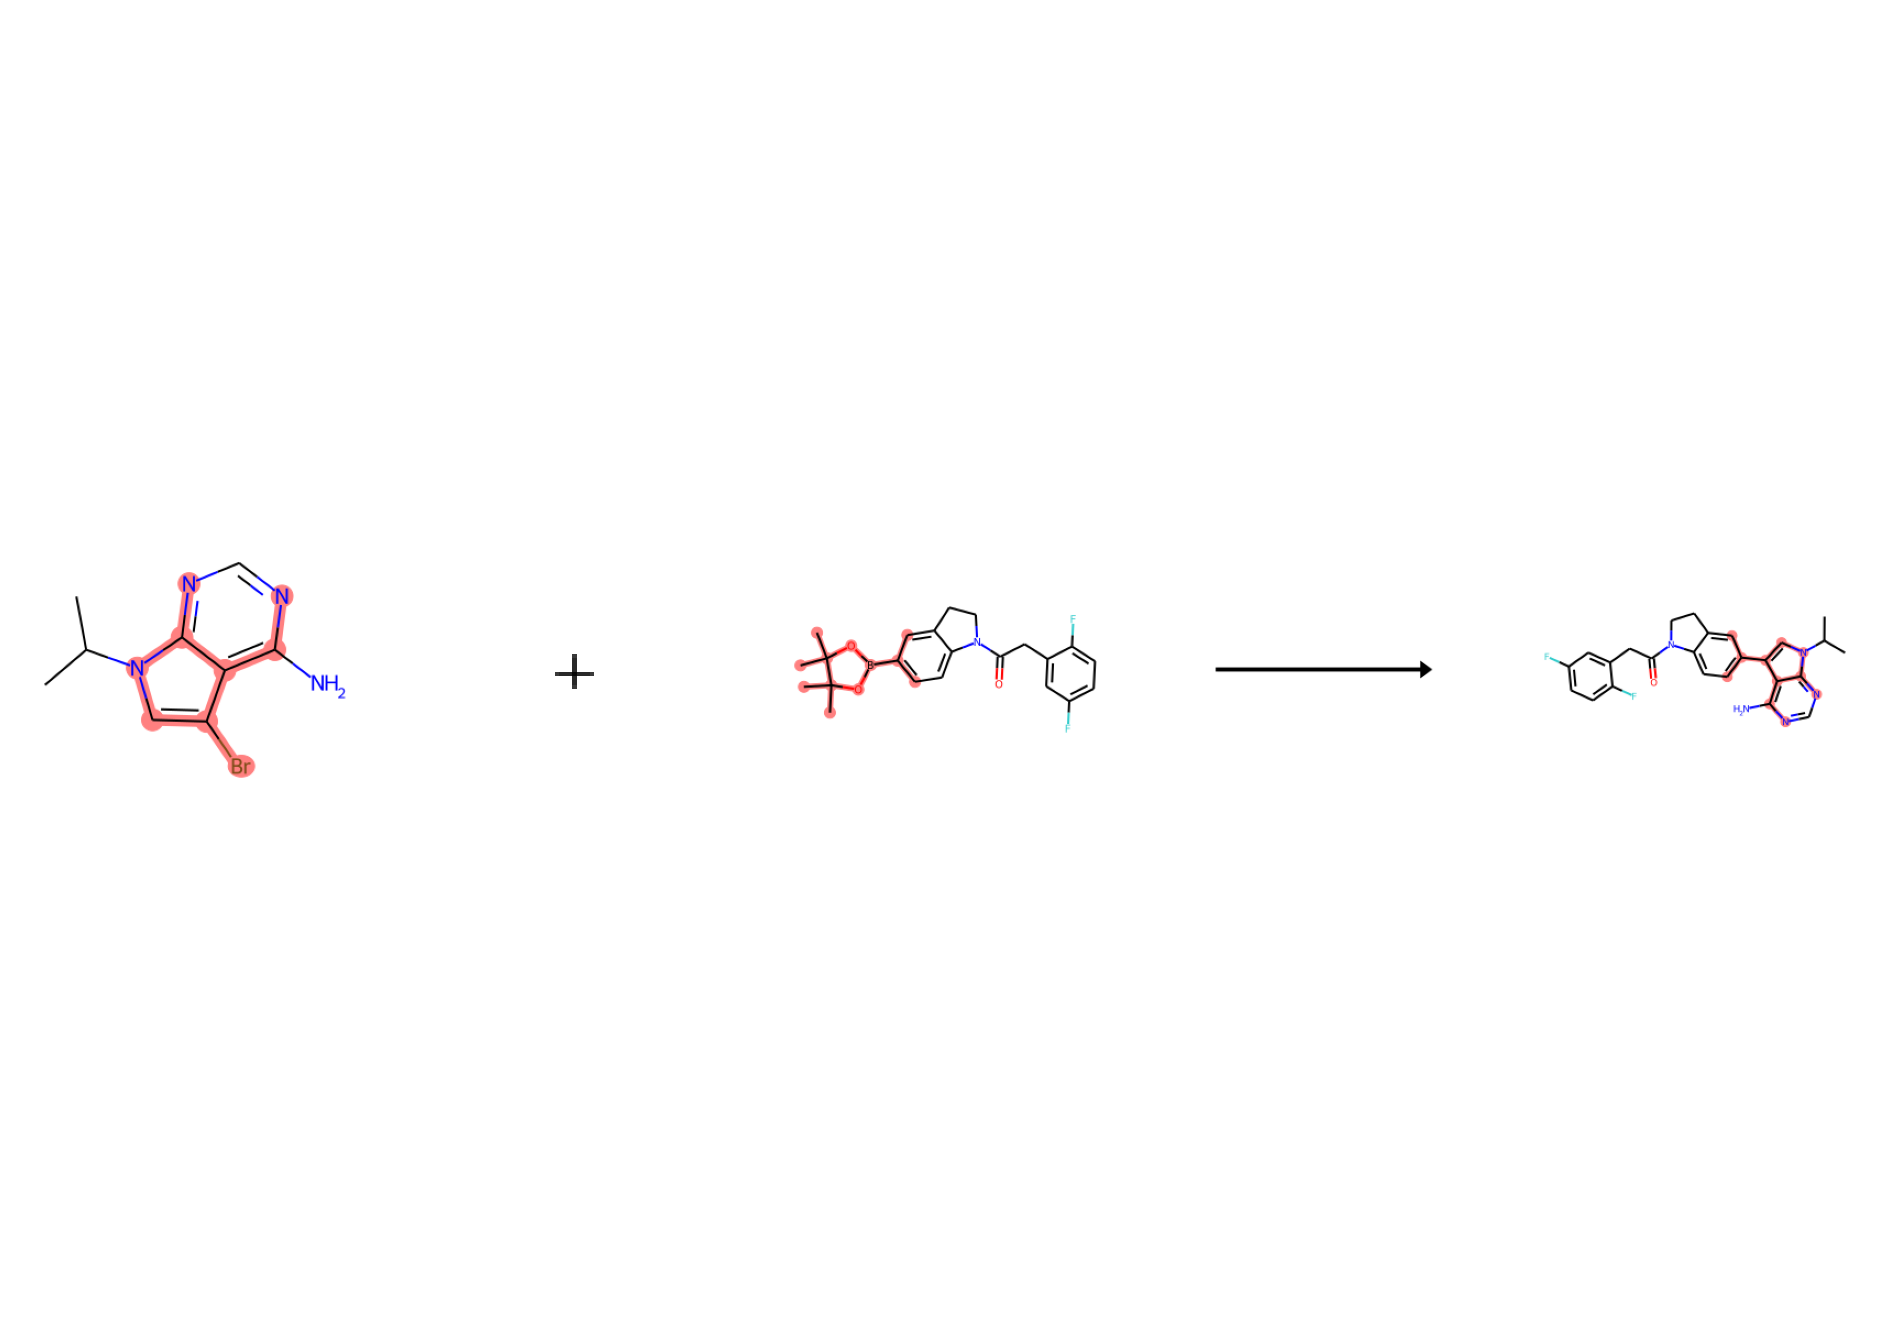

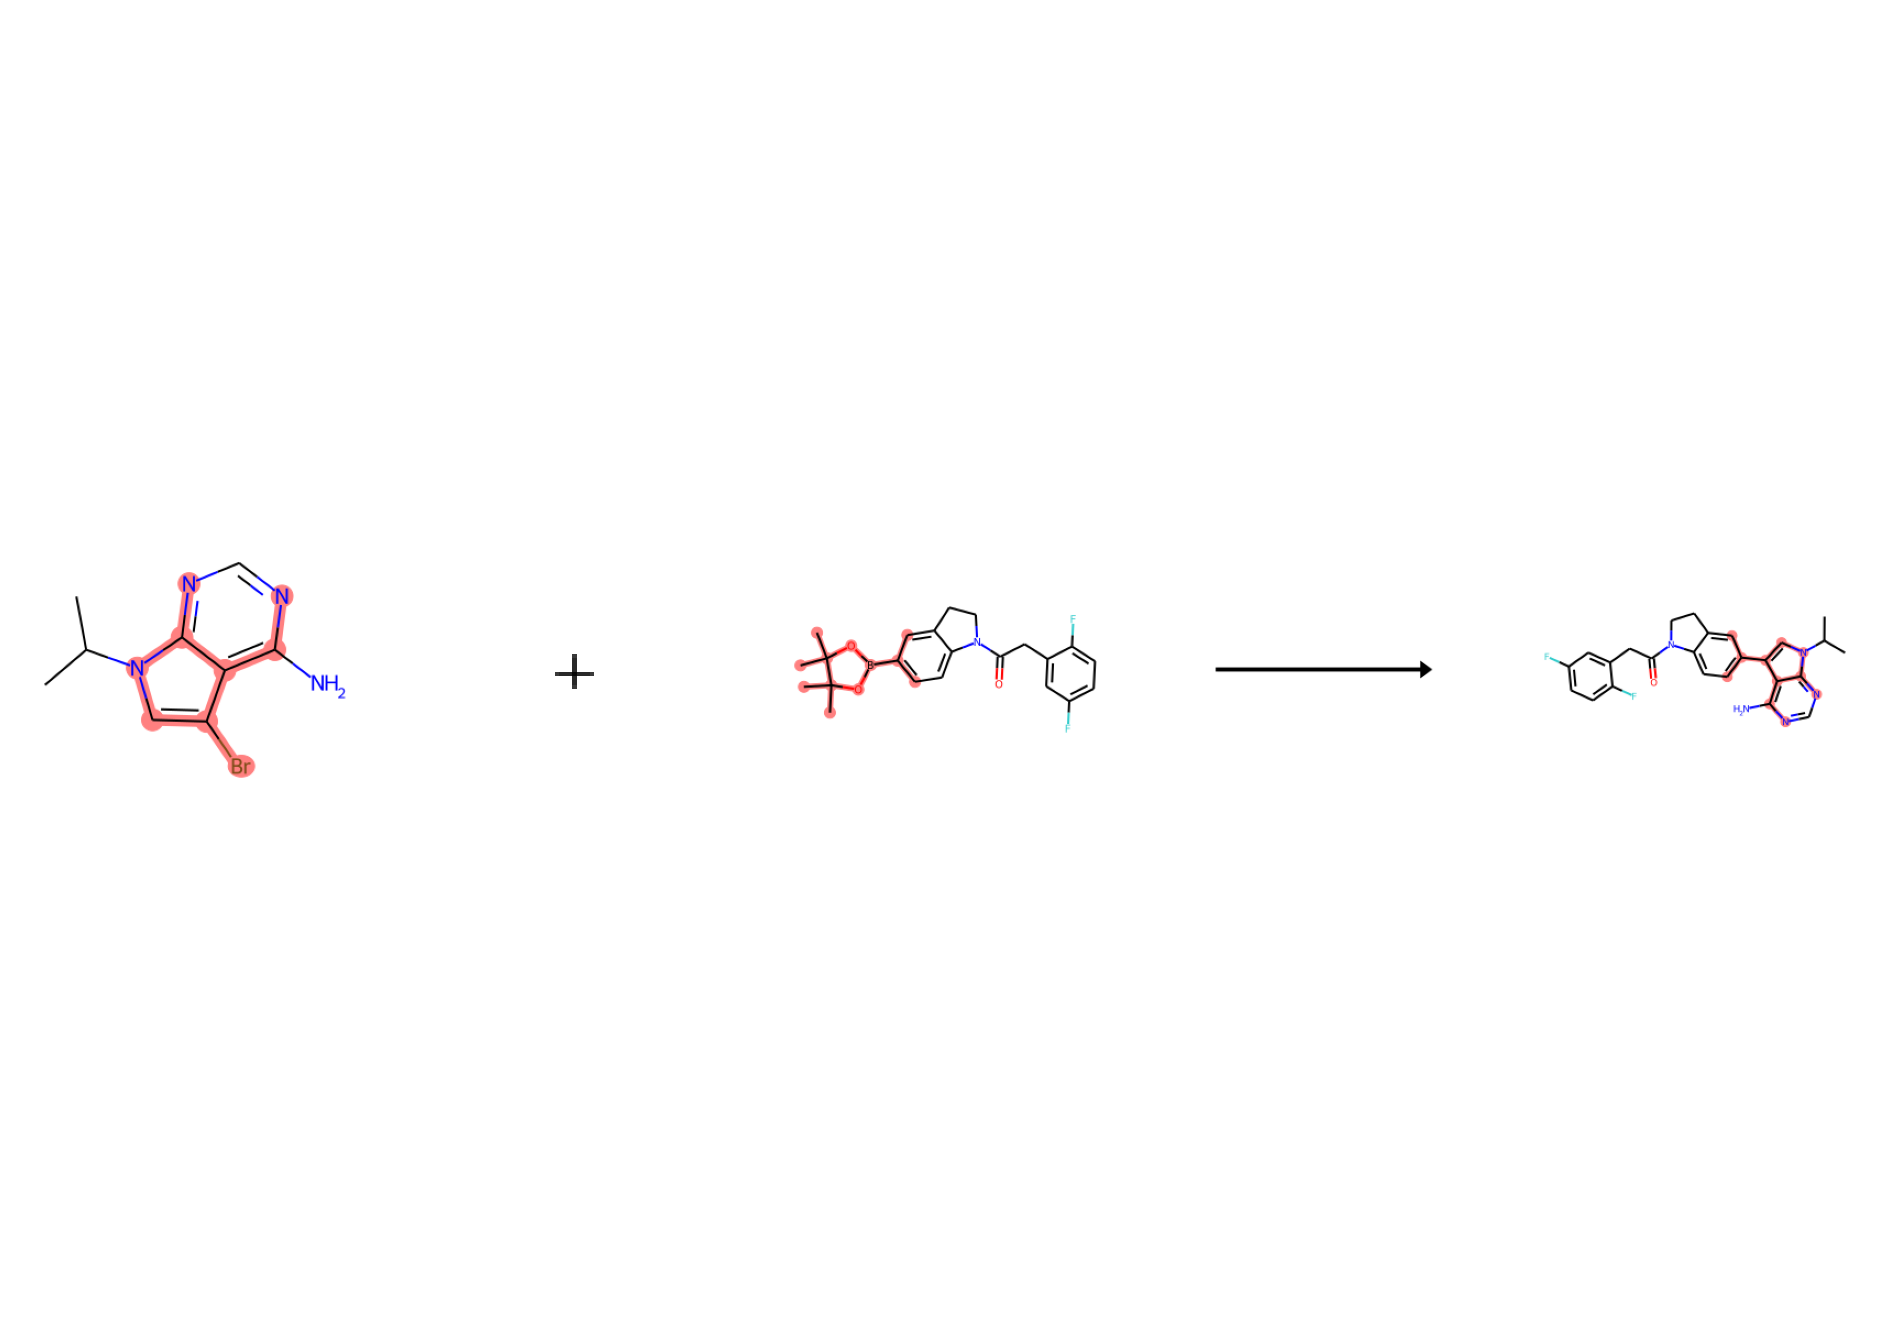

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.


['c1ccc([P](c2ccccc2)(c2ccccc2)[Pd]([P](c2ccccc2)(c2ccccc2)c2ccccc2)([P](c2ccccc2)(c2ccccc2)c2ccccc2)[P](c2ccccc2)(c2ccccc2)c2ccccc2)cc1', 'C1COCCO1', 'O', 'O=C([O-])O.[Na+]', '']
torch.Size([3, 4, 133, 5])
133
['c1ccc([P](c2ccccc2)(c2ccccc2)[Pd]([P](c2ccccc2)(c2ccccc2)c2ccccc2)([P](c2ccccc2)(c2ccccc2)c2ccccc2)[P](c2ccccc2)(c2ccccc2)c2ccccc2)cc1', 'C1COCCO1', '', 'O=C([O-])O.[Na+]', '']


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


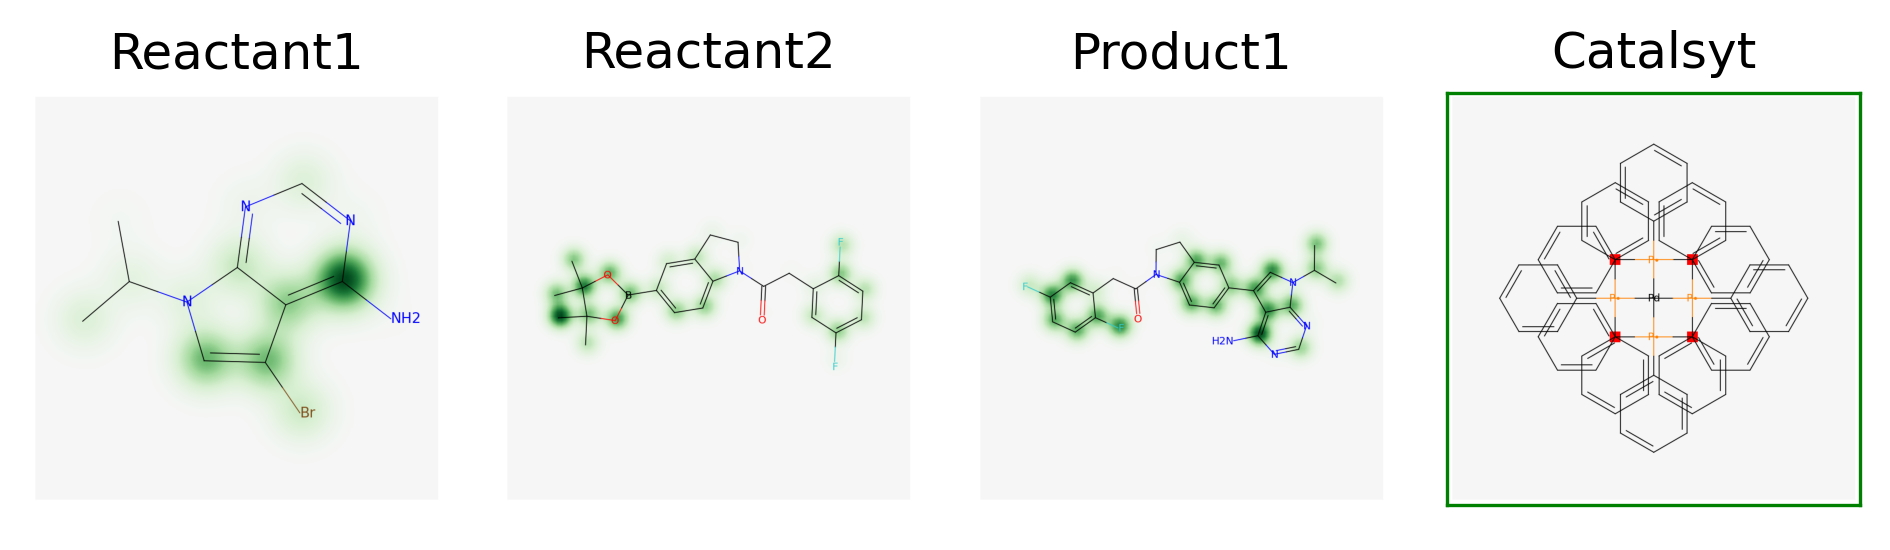

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.


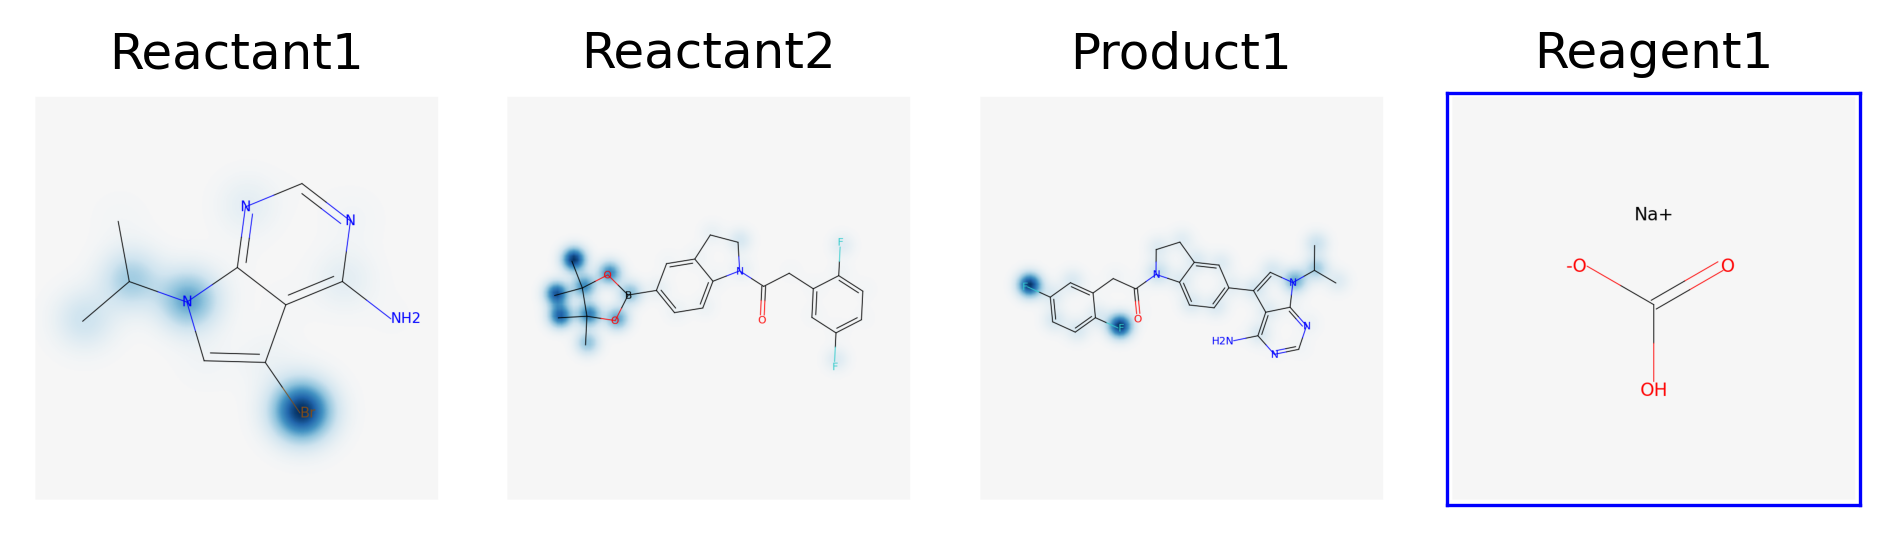

/home/xiaoruiwang/software/miniconda3/envs/retro_planner_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


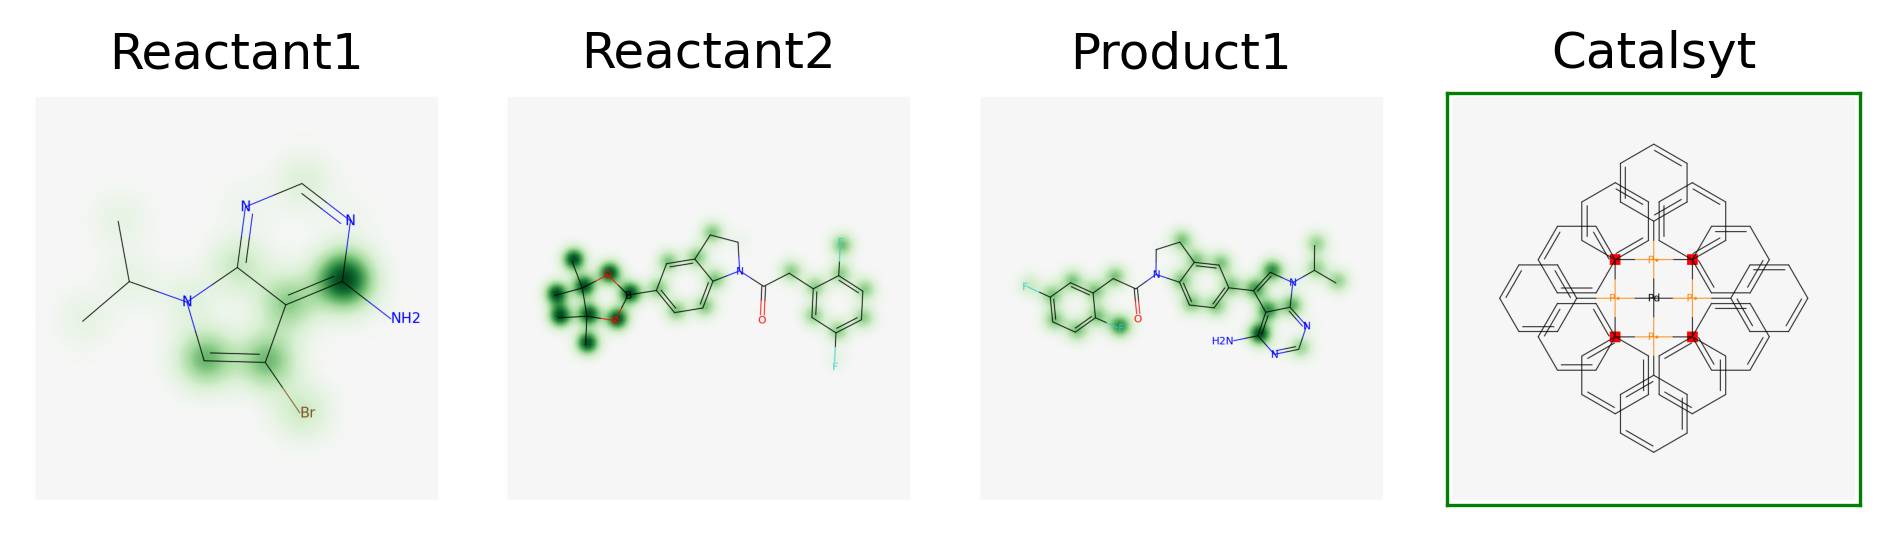

/home/xiaoruiwang/software/miniconda3/envs/retro_planner_env/lib/python3.7/site-packages/rdkit/Chem/Draw/mplCanvas.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = figure(figsize=figsize)


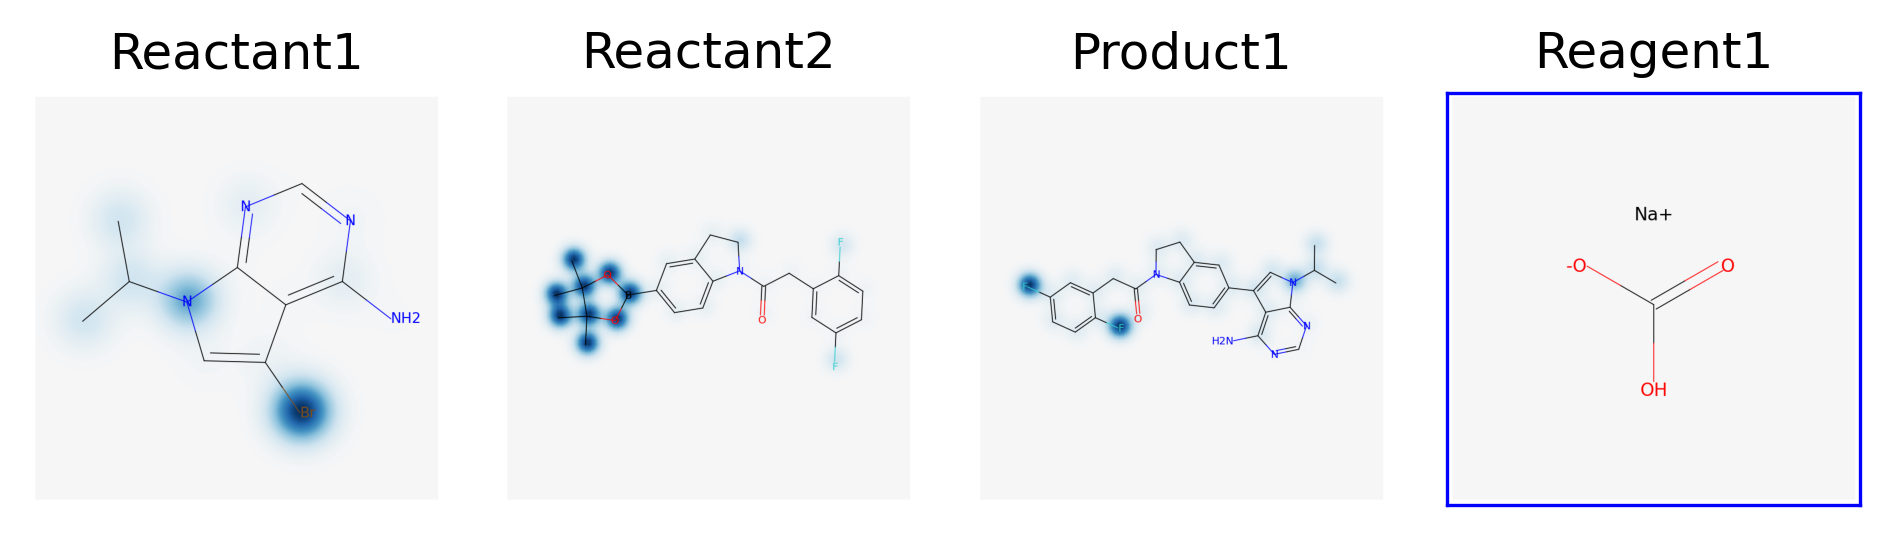

In [8]:
%matplotlib
idx = 0
rxn_smiles = input_df['canonical_rxn'].tolist()[idx]
gt_retro_template = input_df['retro_template'].tolist()[idx]
pred_retro_template = input_df['self_encoder_mapped_tpl'].tolist()[idx]
print(rxn_smiles)
print(gt_retro_template)
print(pred_retro_template)
show_rxn_with_highlight(rxn_smiles, gt_retro_template, pred_retro_template, save_path='attn_viz/test_rxn2rxn_{}_{}'.format(reaction_class.replace(' ', '_'), idx))
predicted_conditions, attention_weights, input_tokens = model.greedy_search_one_sample_with_attn(input_df['canonical_rxn'].tolist()[idx])
print(predicted_conditions)
print(attention_weights.shape)
print(len(input_tokens))
print(input_df['ground_truth_conditions'].tolist()[idx])

vis_attention_for_reaction(attention_weights, src_tokens=input_tokens, tgt_tokens=predicted_conditions, rxn_smiles=input_df['canonical_rxn'].tolist()[idx], output_fig_folder='attn_viz/test_rxn2condition_{}_{}'.format(reaction_class.replace(' ', '_'), idx))
vis_attention_for_reaction_mean_by_functional_group(attention_weights, src_tokens=input_tokens, tgt_tokens=predicted_conditions, rxn_smiles=input_df['canonical_rxn'].tolist()[idx], output_fig_folder='attn_viz/test_rxn2condition_{}_{}'.format(reaction_class.replace(' ', '_'), idx), functional_group_path='eval_data/group_attn_results/subgraph.csv')

Using matplotlib backend: agg
CC[C@@H](C)Nc1nc2cc(C(=O)OC)ccc2nc1OS(=O)(=O)C(F)(F)F.OB(O)c1cc2cc(F)ccc2o1>>CC[C@@H](C)Nc1nc2cc(C(=O)OC)ccc2nc1-c1cc2cc(F)ccc2o1
[#7;a:2]:[c;H0;D3;+0:1](:[c:3]:[#7;a:4])-[c;H0;D3;+0:5](:[#8;a:6]):[c:7]>>F-C(-F)(-F)-S(=O)(=O)-O-[c;H0;D3;+0:1](:[#7;a:2]):[c:3]:[#7;a:4].O-B(-O)-[c;H0;D3;+0:5](:[#8;a:6]):[c:7]
[#7;a:2]:[c;H0;D3;+0:1](:[c:3]:[#7;a:4])-[c;H0;D3;+0:5](:[#8;a:6]):[c:7]>>F-C(-F)(-F)-S(=O)(=O)-O-[c;H0;D3;+0:1](:[#7;a:2]):[c:3]:[#7;a:4].O-B(-O)-[c;H0;D3;+0:5](:[#8;a:6]):[c:7]


/home/xiaoruiwang/software/miniconda3/envs/retro_planner_env/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


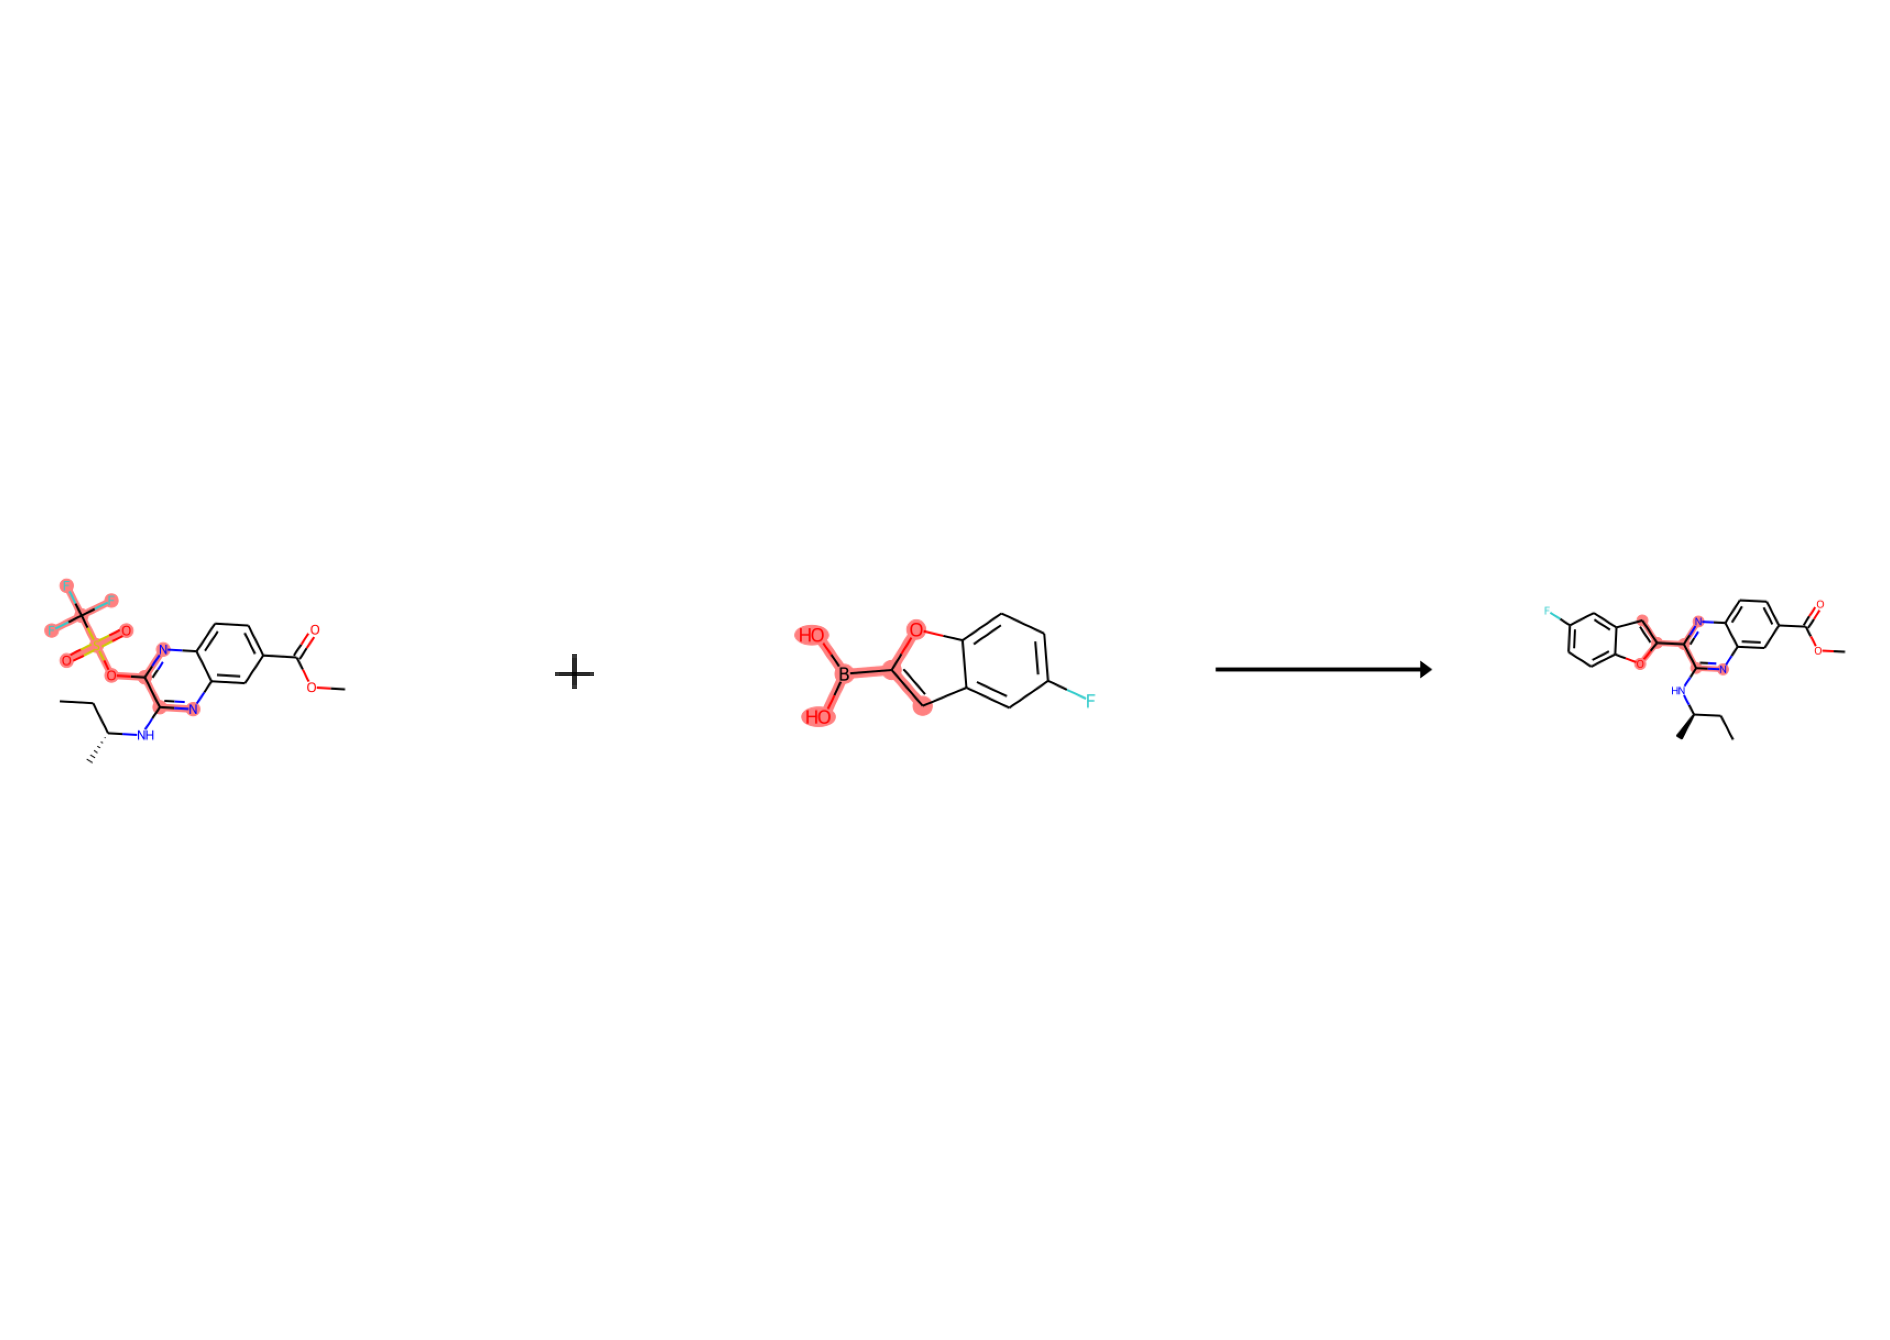

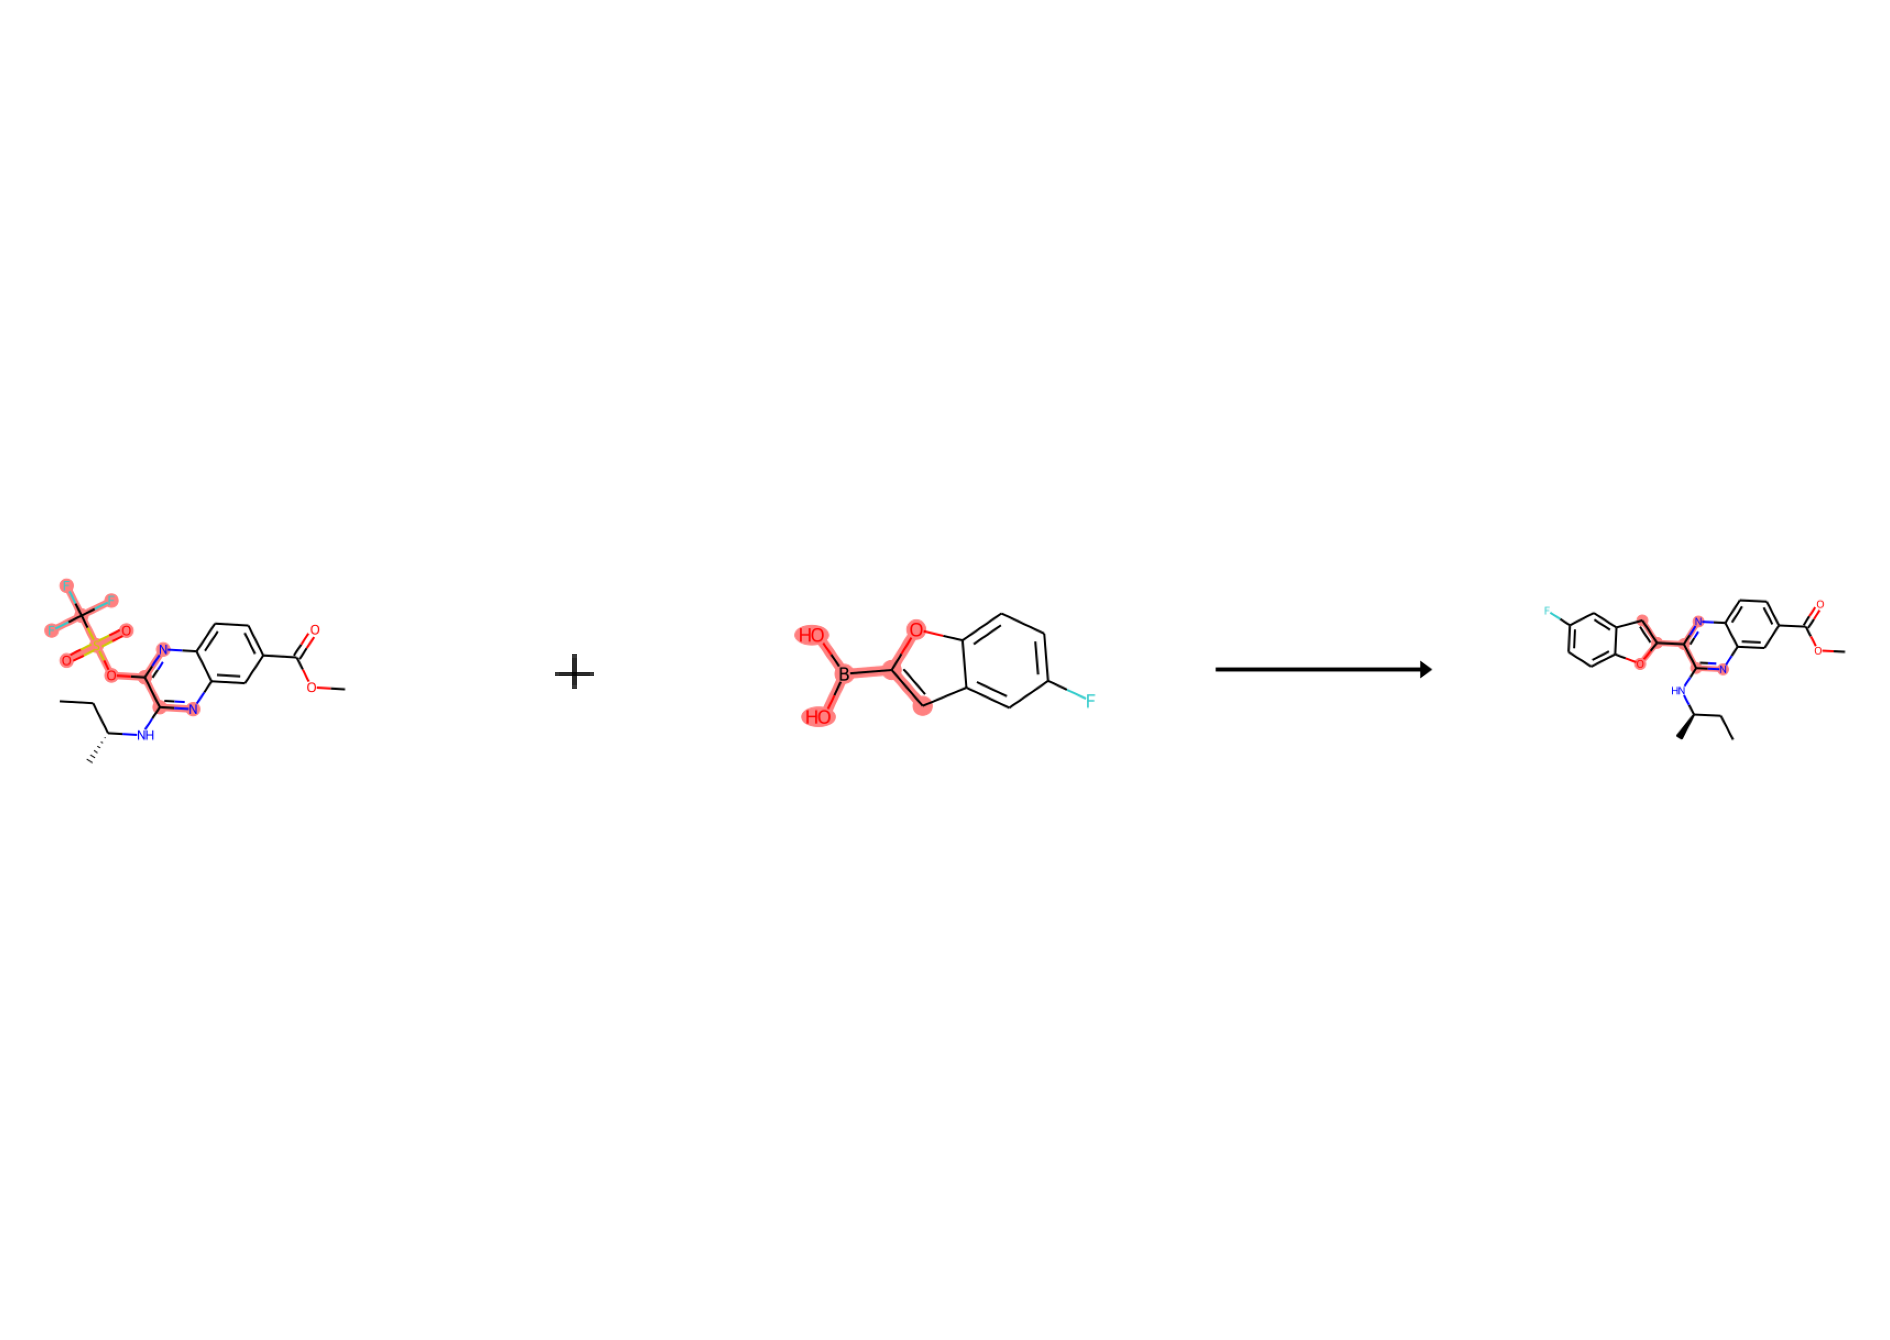

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.


['c1ccc([P](c2ccccc2)(c2ccccc2)[Pd]([P](c2ccccc2)(c2ccccc2)c2ccccc2)([P](c2ccccc2)(c2ccccc2)c2ccccc2)[P](c2ccccc2)(c2ccccc2)c2ccccc2)cc1', 'C1COCCO1', '', 'O', 'O=C([O-])[O-].[Na+].[Na+]']
torch.Size([3, 4, 118, 5])
118
['c1ccc([P](c2ccccc2)(c2ccccc2)[Pd]([P](c2ccccc2)(c2ccccc2)c2ccccc2)([P](c2ccccc2)(c2ccccc2)c2ccccc2)[P](c2ccccc2)(c2ccccc2)c2ccccc2)cc1', 'C1COCCO1', '', 'O=P([O-])([O-])[O-].[K+].[K+].[K+]', '']


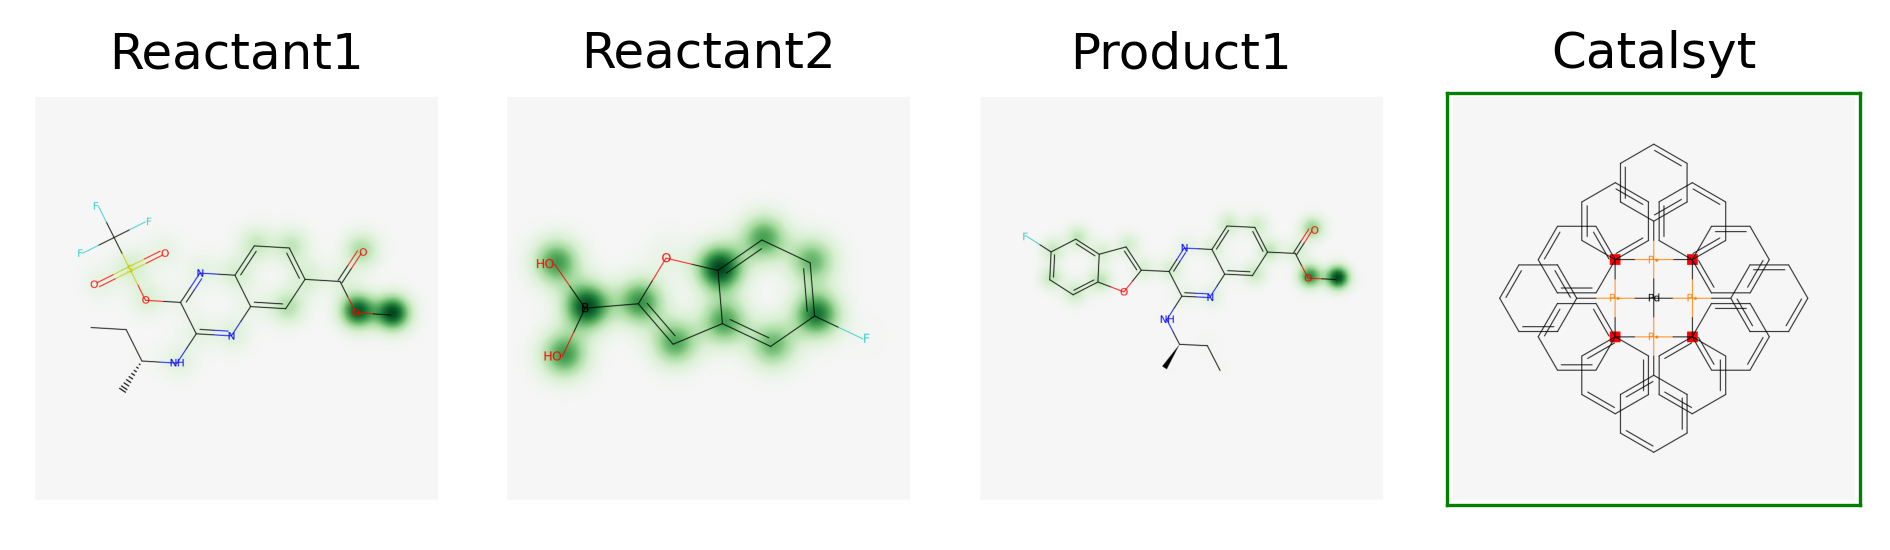

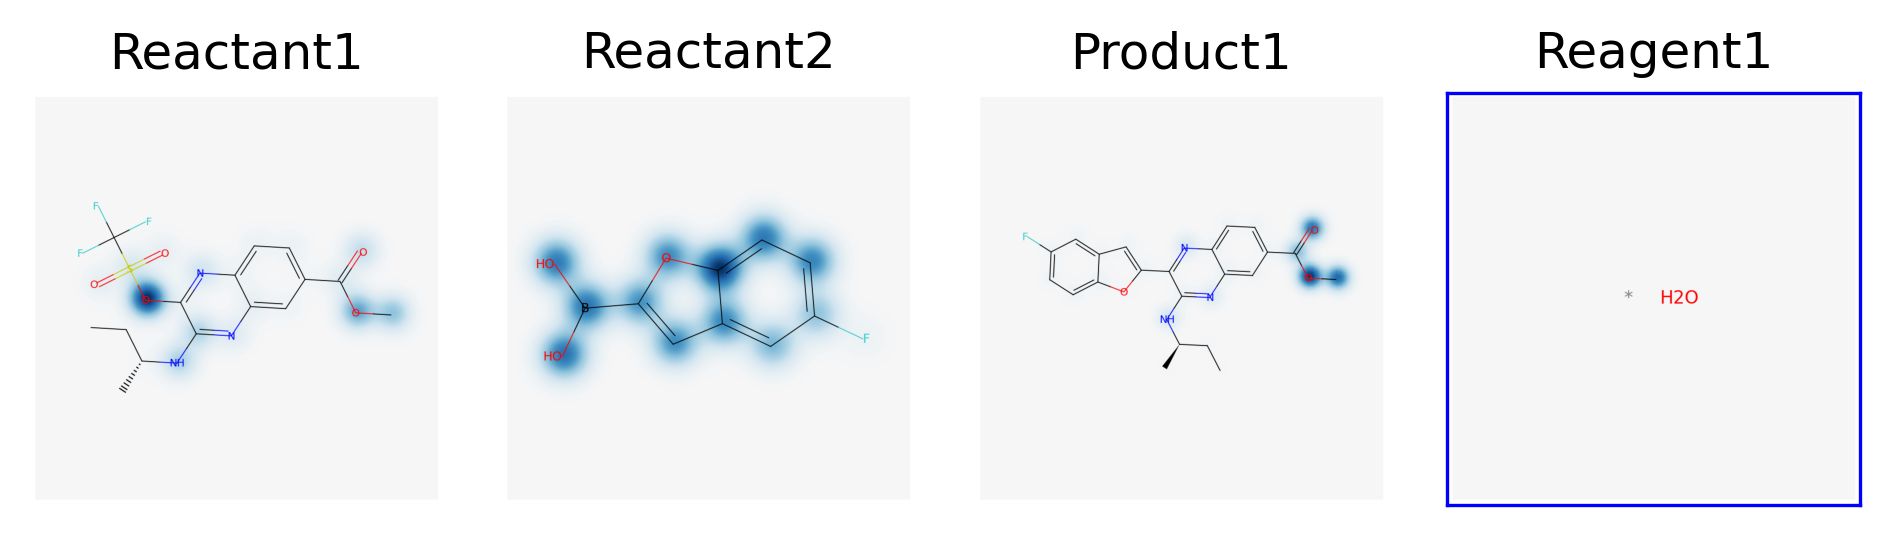

/home/xiaoruiwang/software/miniconda3/envs/retro_planner_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


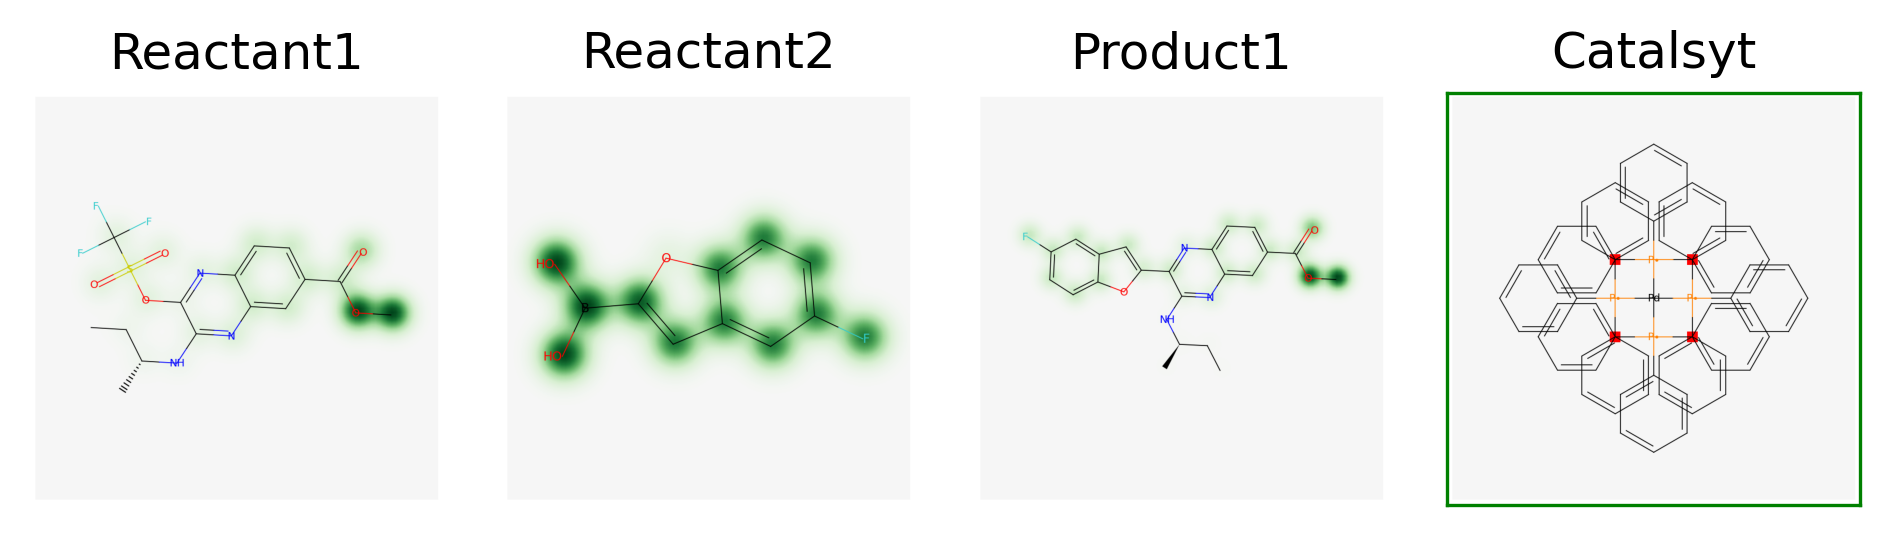

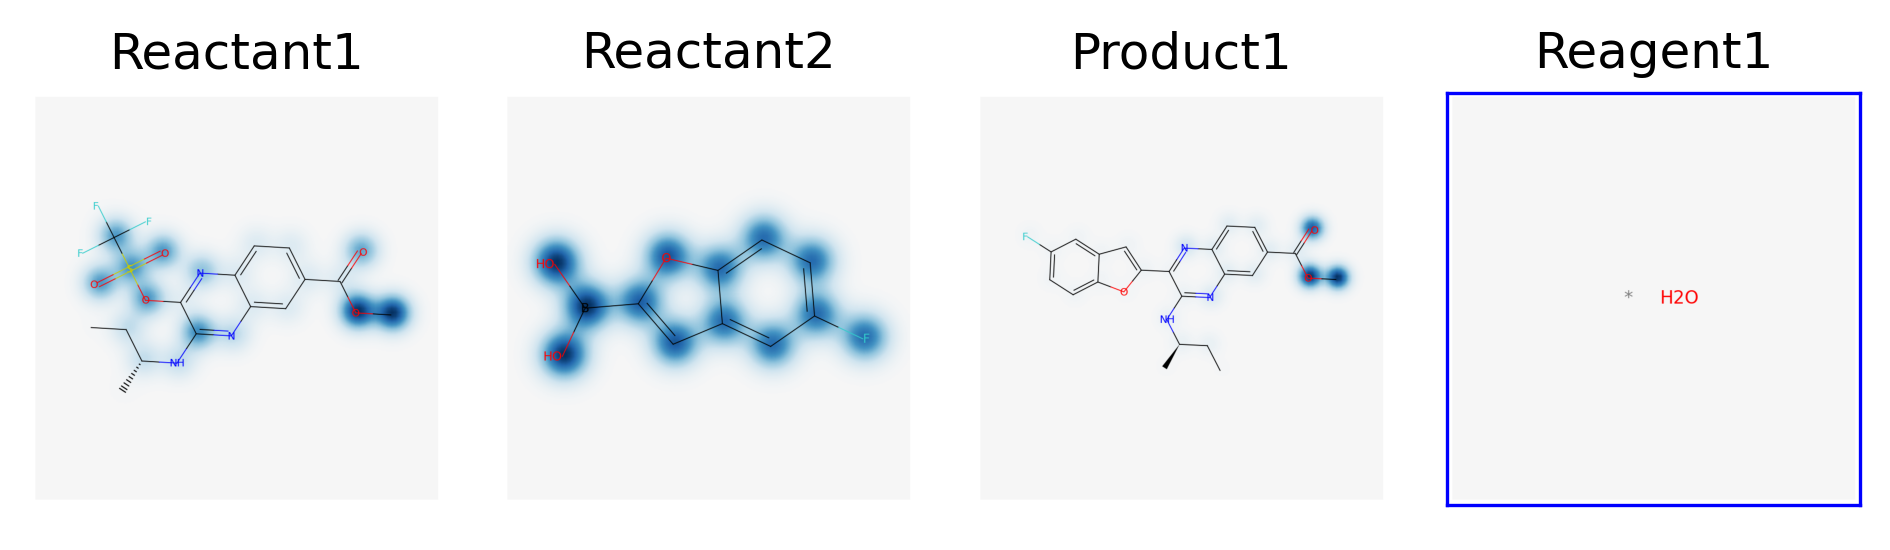

In [9]:
%matplotlib
idx = 6
rxn_smiles = input_df['canonical_rxn'].tolist()[idx]
gt_retro_template = input_df['retro_template'].tolist()[idx]
pred_retro_template = input_df['self_encoder_mapped_tpl'].tolist()[idx]
print(rxn_smiles)
print(gt_retro_template)
print(pred_retro_template)
show_rxn_with_highlight(rxn_smiles, gt_retro_template, pred_retro_template, save_path='attn_viz/test_rxn2rxn_{}_{}'.format(reaction_class.replace(' ', '_'), idx))
predicted_conditions, attention_weights, input_tokens = model.greedy_search_one_sample_with_attn(input_df['canonical_rxn'].tolist()[idx])
print(predicted_conditions)
print(attention_weights.shape)
print(len(input_tokens))
print(input_df['ground_truth_conditions'].tolist()[idx])

vis_attention_for_reaction(attention_weights, src_tokens=input_tokens, tgt_tokens=predicted_conditions, rxn_smiles=input_df['canonical_rxn'].tolist()[idx], output_fig_folder='attn_viz/test_rxn2condition_{}_{}'.format(reaction_class.replace(' ', '_'), idx))
vis_attention_for_reaction_mean_by_functional_group(attention_weights, src_tokens=input_tokens, tgt_tokens=predicted_conditions, rxn_smiles=input_df['canonical_rxn'].tolist()[idx], output_fig_folder='attn_viz/test_rxn2condition_{}_{}'.format(reaction_class.replace(' ', '_'), idx), functional_group_path='eval_data/group_attn_results/subgraph.csv')

Using matplotlib backend: agg
Cc1cnc(Oc2ccccc2)c(Br)c1.OB(O)c1ccc(Cl)cc1>>Cc1cnc(Oc2ccccc2)c(-c2ccc(Cl)cc2)c1
[#7;a:4]:[c:3]:[c;H0;D3;+0:1](:[c:2])-[c;H0;D3;+0:5](:[c:6]):[c:7]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3]:[#7;a:4].O-B(-O)-[c;H0;D3;+0:5](:[c:6]):[c:7]
[#7;a:4]:[c:3]:[c;H0;D3;+0:1](:[c:2])-[c;H0;D3;+0:5](:[c:6]):[c:7]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3]:[#7;a:4].O-B(-O)-[c;H0;D3;+0:5](:[c:6]):[c:7]


/home/xiaoruiwang/software/miniconda3/envs/retro_planner_env/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


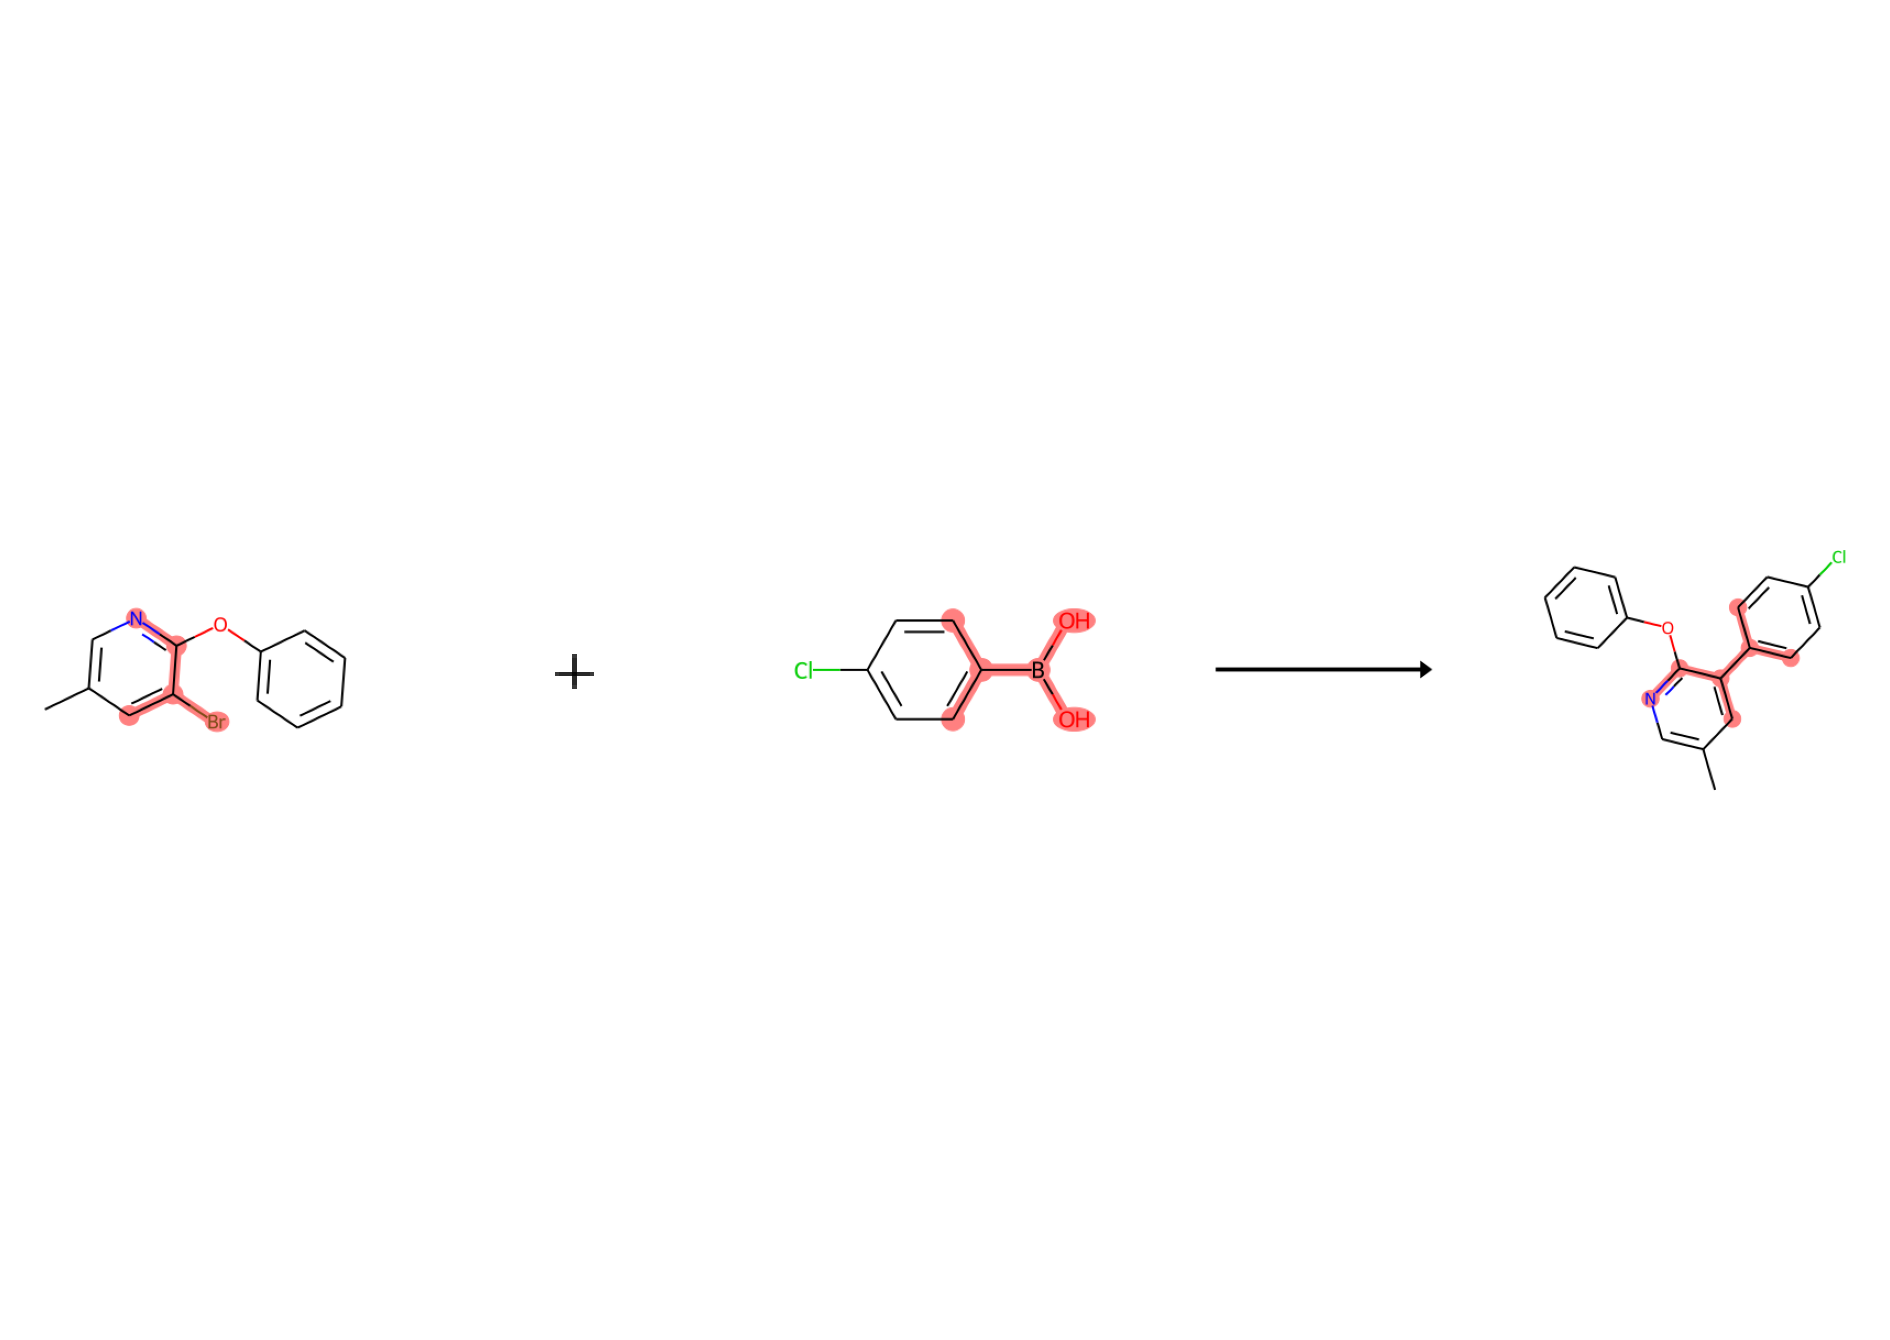

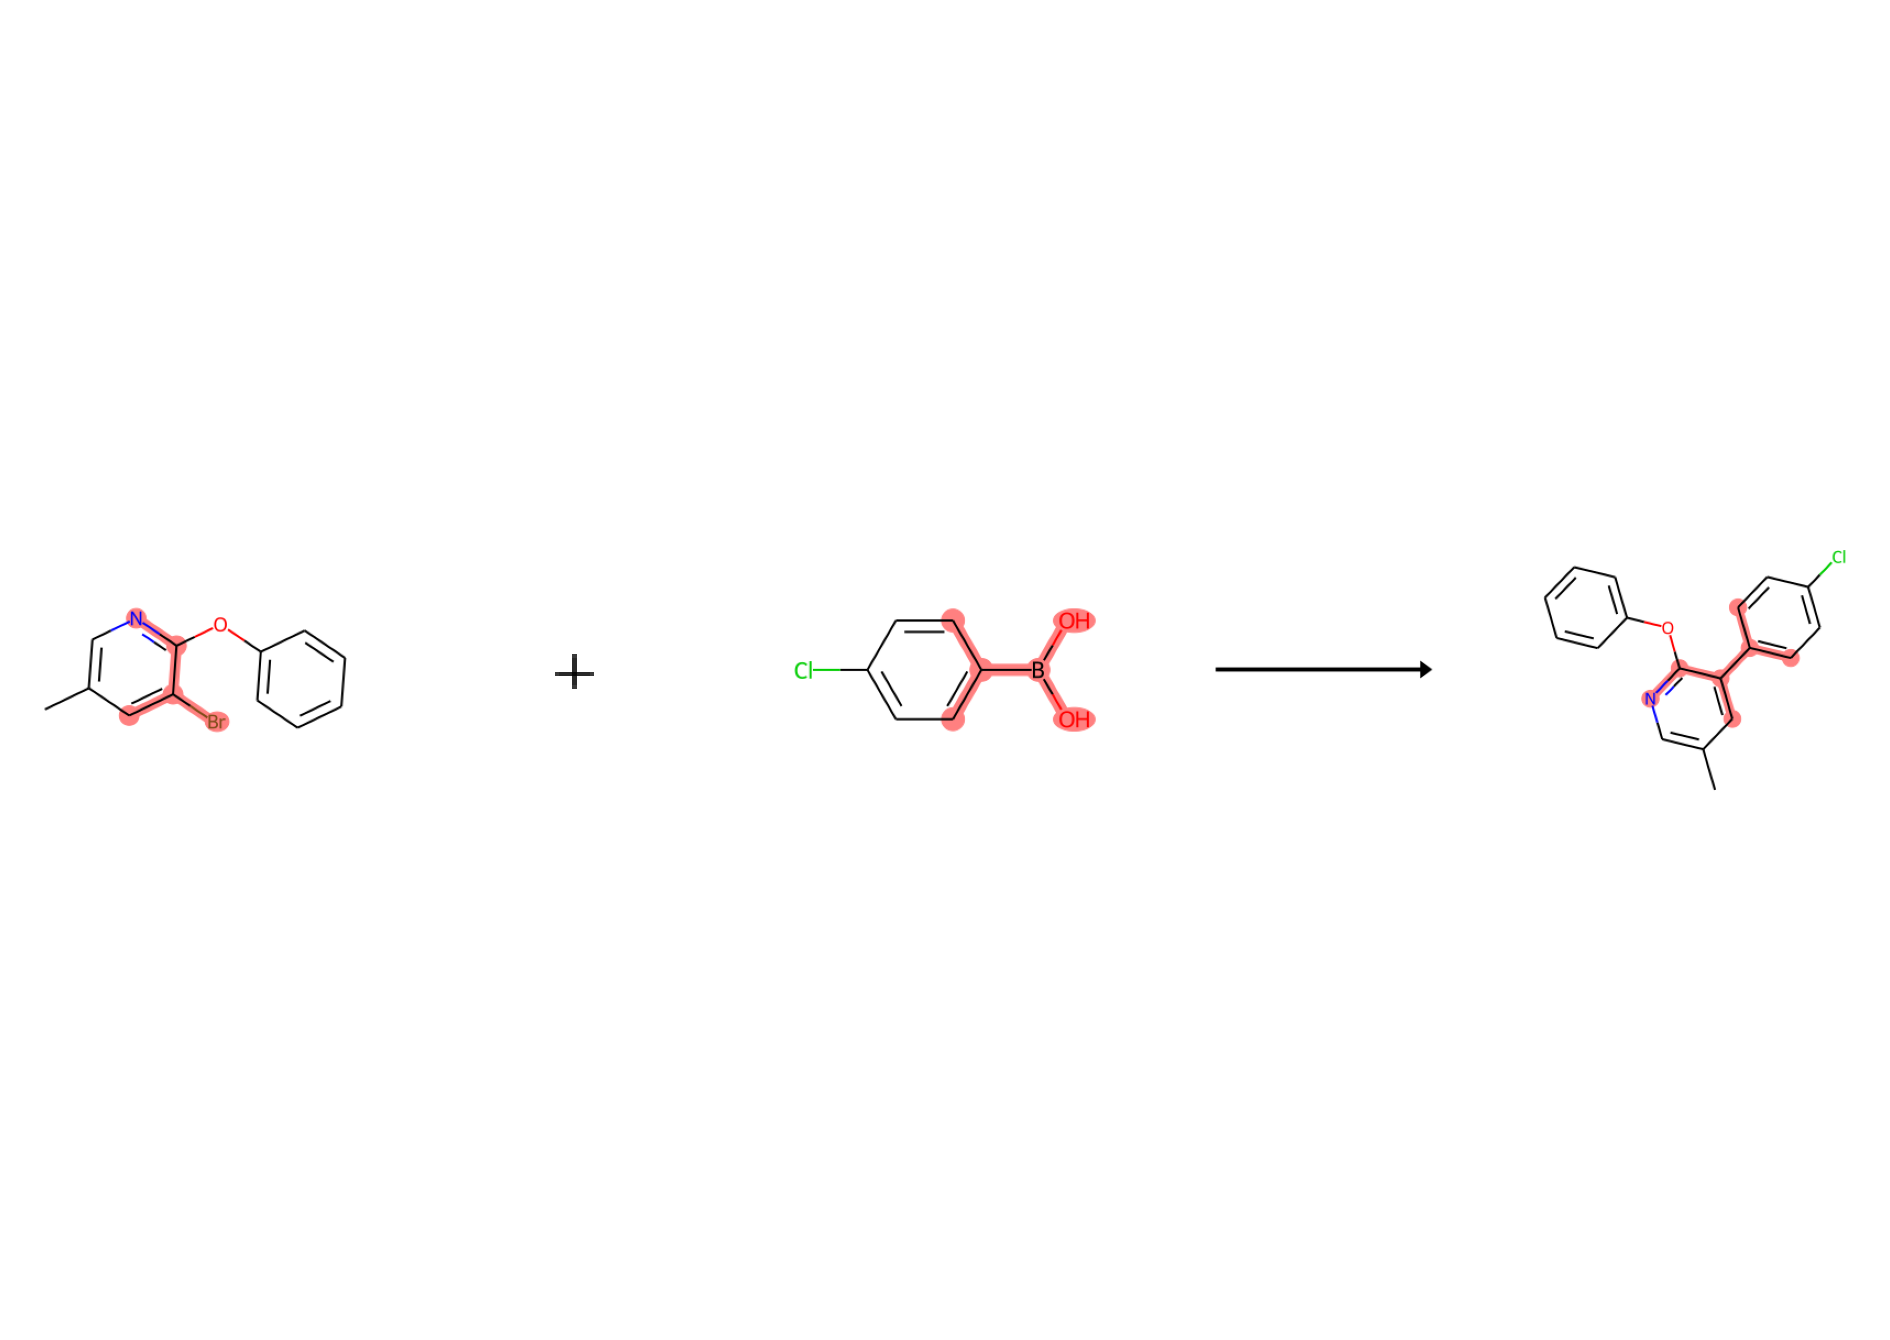

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.


['c1ccc([P](c2ccccc2)(c2ccccc2)[Pd]([P](c2ccccc2)(c2ccccc2)c2ccccc2)([P](c2ccccc2)(c2ccccc2)c2ccccc2)[P](c2ccccc2)(c2ccccc2)c2ccccc2)cc1', 'COCCOC', 'O', 'O=C([O-])[O-].[Na+].[Na+]', '']
torch.Size([3, 4, 75, 5])
75
['', 'Cc1ccccc1', '', 'O=C([O-])[O-].[Na+].[Na+]', '']


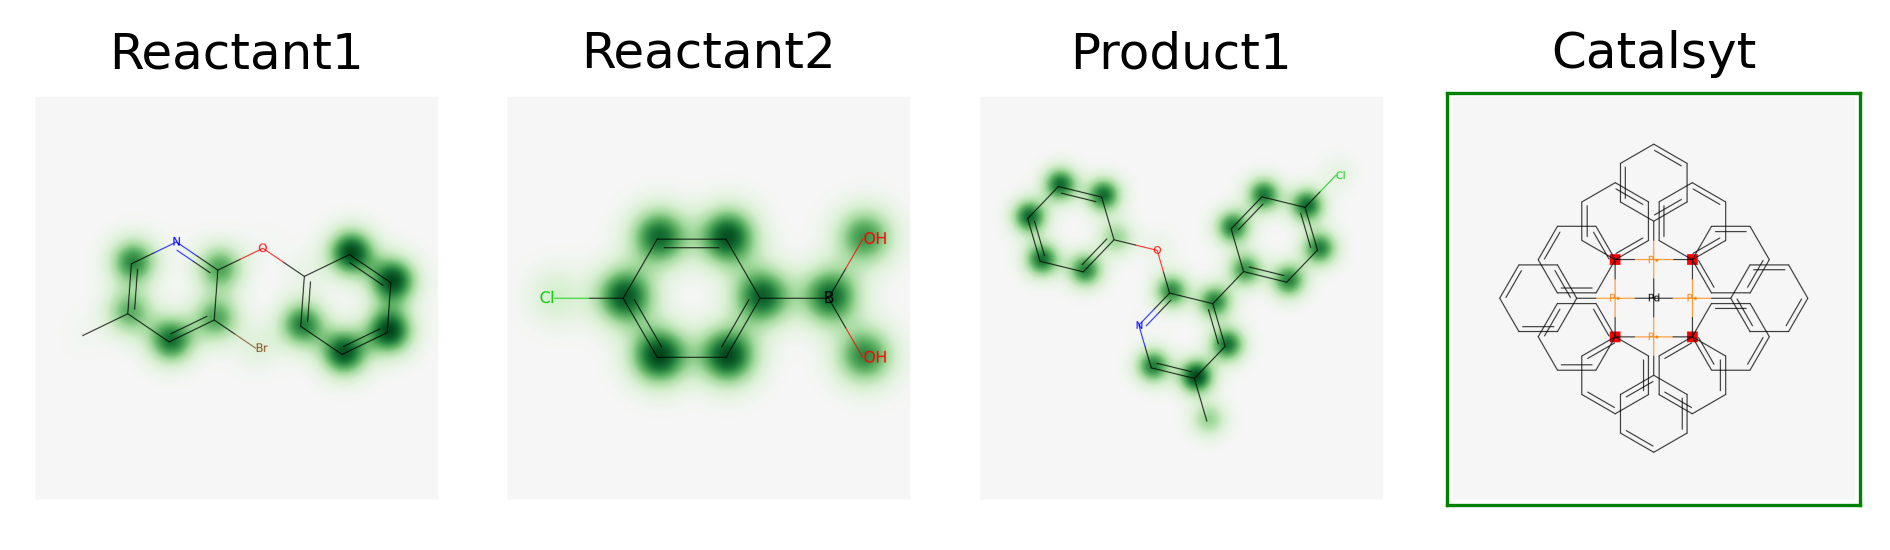

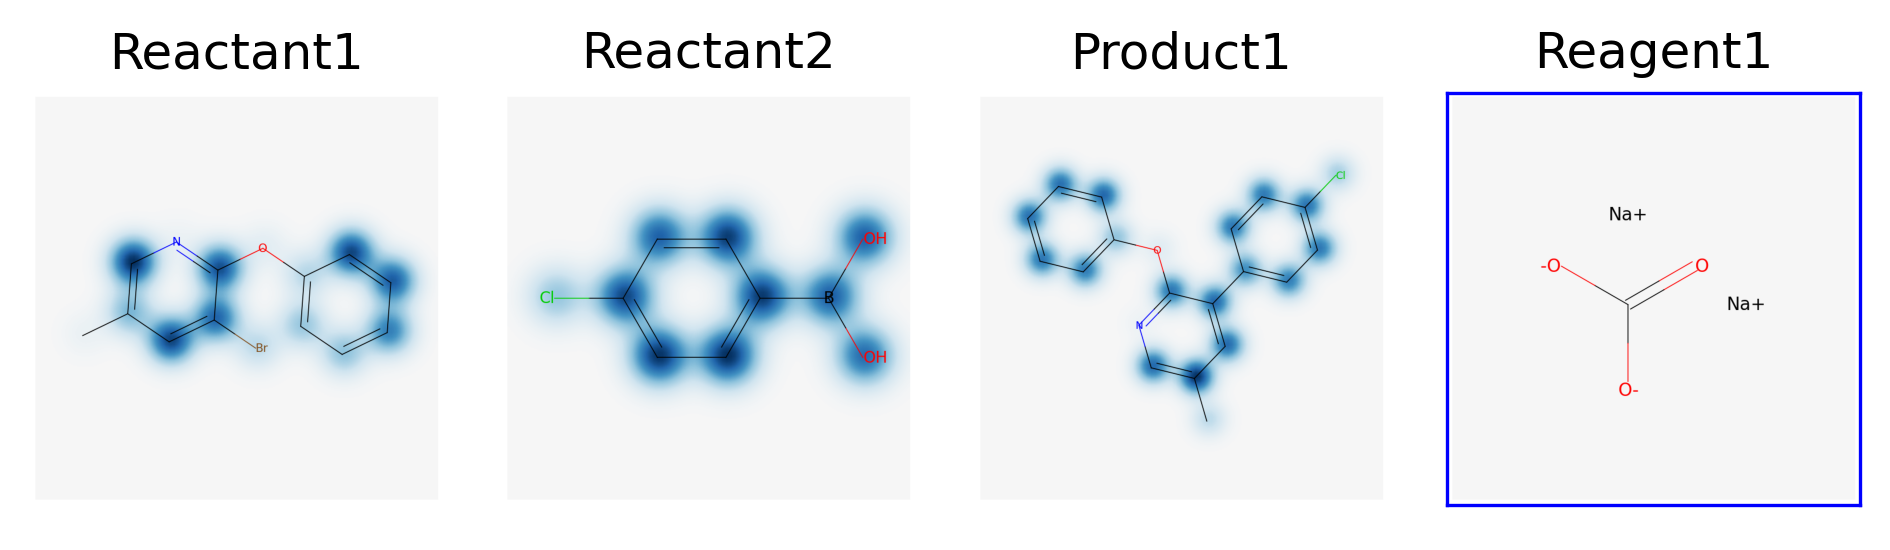

/home/xiaoruiwang/software/miniconda3/envs/retro_planner_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


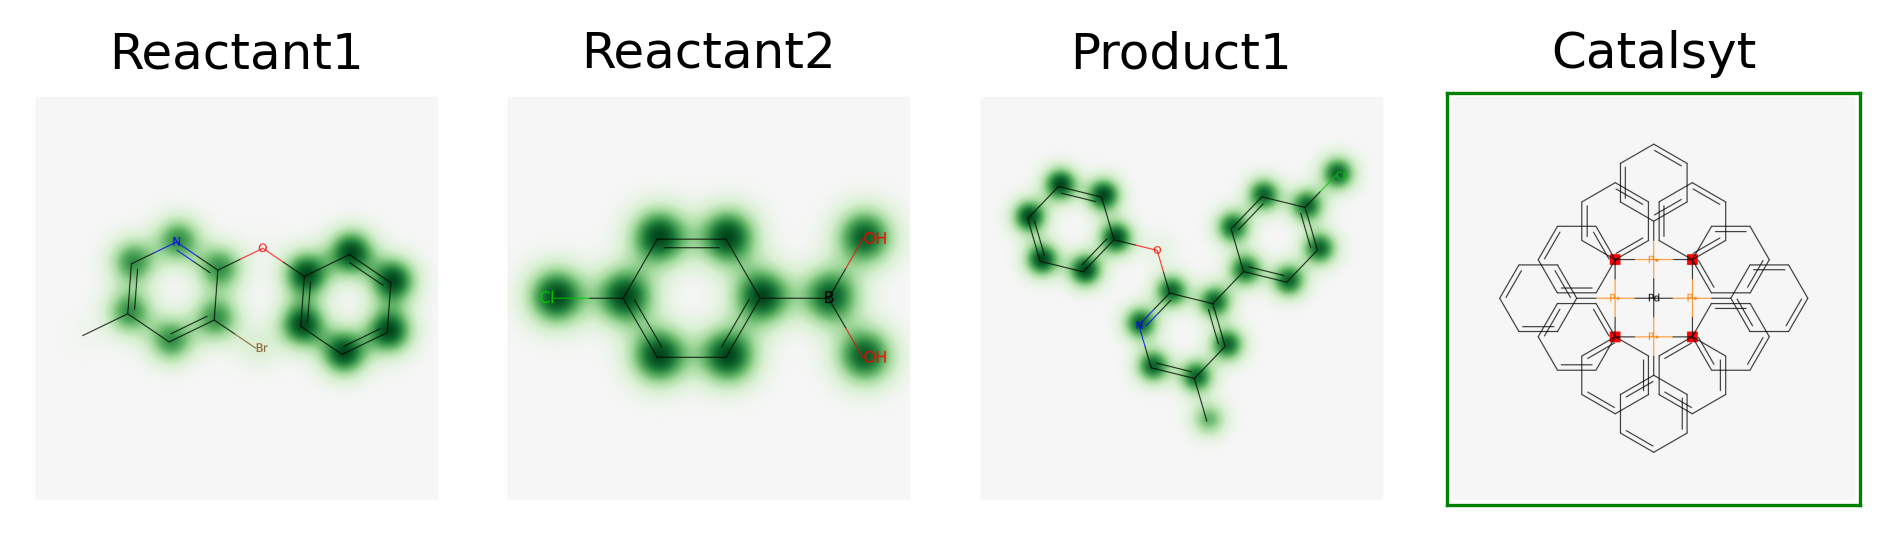

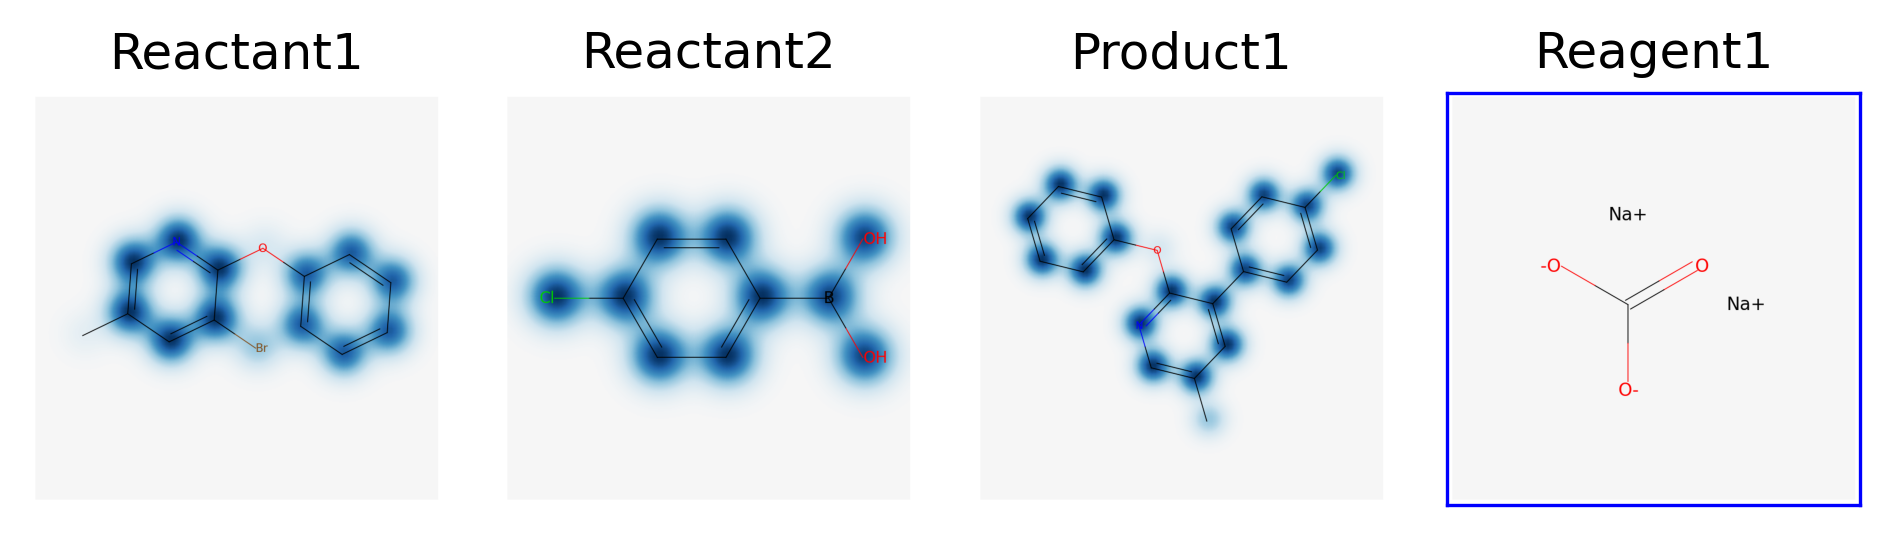

In [10]:
%matplotlib
idx = 99
rxn_smiles = input_df['canonical_rxn'].tolist()[idx]
gt_retro_template = input_df['retro_template'].tolist()[idx]
pred_retro_template = input_df['self_encoder_mapped_tpl'].tolist()[idx]
print(rxn_smiles)
print(gt_retro_template)
print(pred_retro_template)
show_rxn_with_highlight(rxn_smiles, gt_retro_template, pred_retro_template, save_path='attn_viz/test_rxn2rxn_{}_{}'.format(reaction_class.replace(' ', '_'), idx))
predicted_conditions, attention_weights, input_tokens = model.greedy_search_one_sample_with_attn(input_df['canonical_rxn'].tolist()[idx])
print(predicted_conditions)
print(attention_weights.shape)
print(len(input_tokens))
print(input_df['ground_truth_conditions'].tolist()[idx])

vis_attention_for_reaction(attention_weights, src_tokens=input_tokens, tgt_tokens=predicted_conditions, rxn_smiles=input_df['canonical_rxn'].tolist()[idx], output_fig_folder='attn_viz/test_rxn2condition_{}_{}'.format(reaction_class.replace(' ', '_'), idx))
vis_attention_for_reaction_mean_by_functional_group(attention_weights, src_tokens=input_tokens, tgt_tokens=predicted_conditions, rxn_smiles=input_df['canonical_rxn'].tolist()[idx], output_fig_folder='attn_viz/test_rxn2condition_{}_{}'.format(reaction_class.replace(' ', '_'), idx), functional_group_path='eval_data/group_attn_results/subgraph.csv')

In [11]:
reaction_class='C-C bond formation'
input_df, model = init_data_and_model(debug=True, input_path=save_path, reaction_class=reaction_class)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.

########################\Attention Evaluation configs:
########################

dataset_args:
  database_fname: USPTO_condition.csv
  dataset_root: dataset/source_dataset/USPTO_condition_final
  use_temperature: false
inference_args:
  beam:
    0: 2
    1: 3
    2: 1
    3: 3
    4: 1
model_args:
  best_model_dir: ./outputs/Parrot_train_in_USPTO_Condition_enhance
  decoder_args:
    d_model: 256
    dim_feedforward: 256
    dropout: 0.1
    nhead: 4
    num_decoder_layers: 3
    tgt_vocab_size: None
  evaluate_during_training: true
  fp16: false
  gradient_accumulation_steps: 1
  learning_rate: 0.0002
  manual_seed: 42
  max_seq_length: 512
  num_train_epochs: 100
  output_dir: ./out/Parrot_train_in_USPTO_Condition_enhance
  overwrite_output_dir: true
  pretrained_path: ./outputs/Parrot_train_in_USPTO_Condition
  regression: false
  thread_co

Using matplotlib backend: agg
C=CCBr.O=Cc1ccc2ccccc2c1>>C=CCC(O)c1ccc2ccccc2c1
[C;D1;H2:3]=[C:2]-[CH2;D2;+0:1]-[CH;D3;+0:5](-[OH;D1;+0:4])-[c:6]>>Br-[CH2;D2;+0:1]-[C:2]=[C;D1;H2:3].[O;H0;D1;+0:4]=[CH;D2;+0:5]-[c:6]
[C;D1;H2:3]=[C:2]-[CH2;D2;+0:1]-[CH;D3;+0:5](-[OH;D1;+0:4])-[c:6]>>Br-[CH2;D2;+0:1]-[C:2]=[C;D1;H2:3].[O;H0;D1;+0:4]=[CH;D2;+0:5]-[c:6]


/home/xiaoruiwang/software/miniconda3/envs/retro_planner_env/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


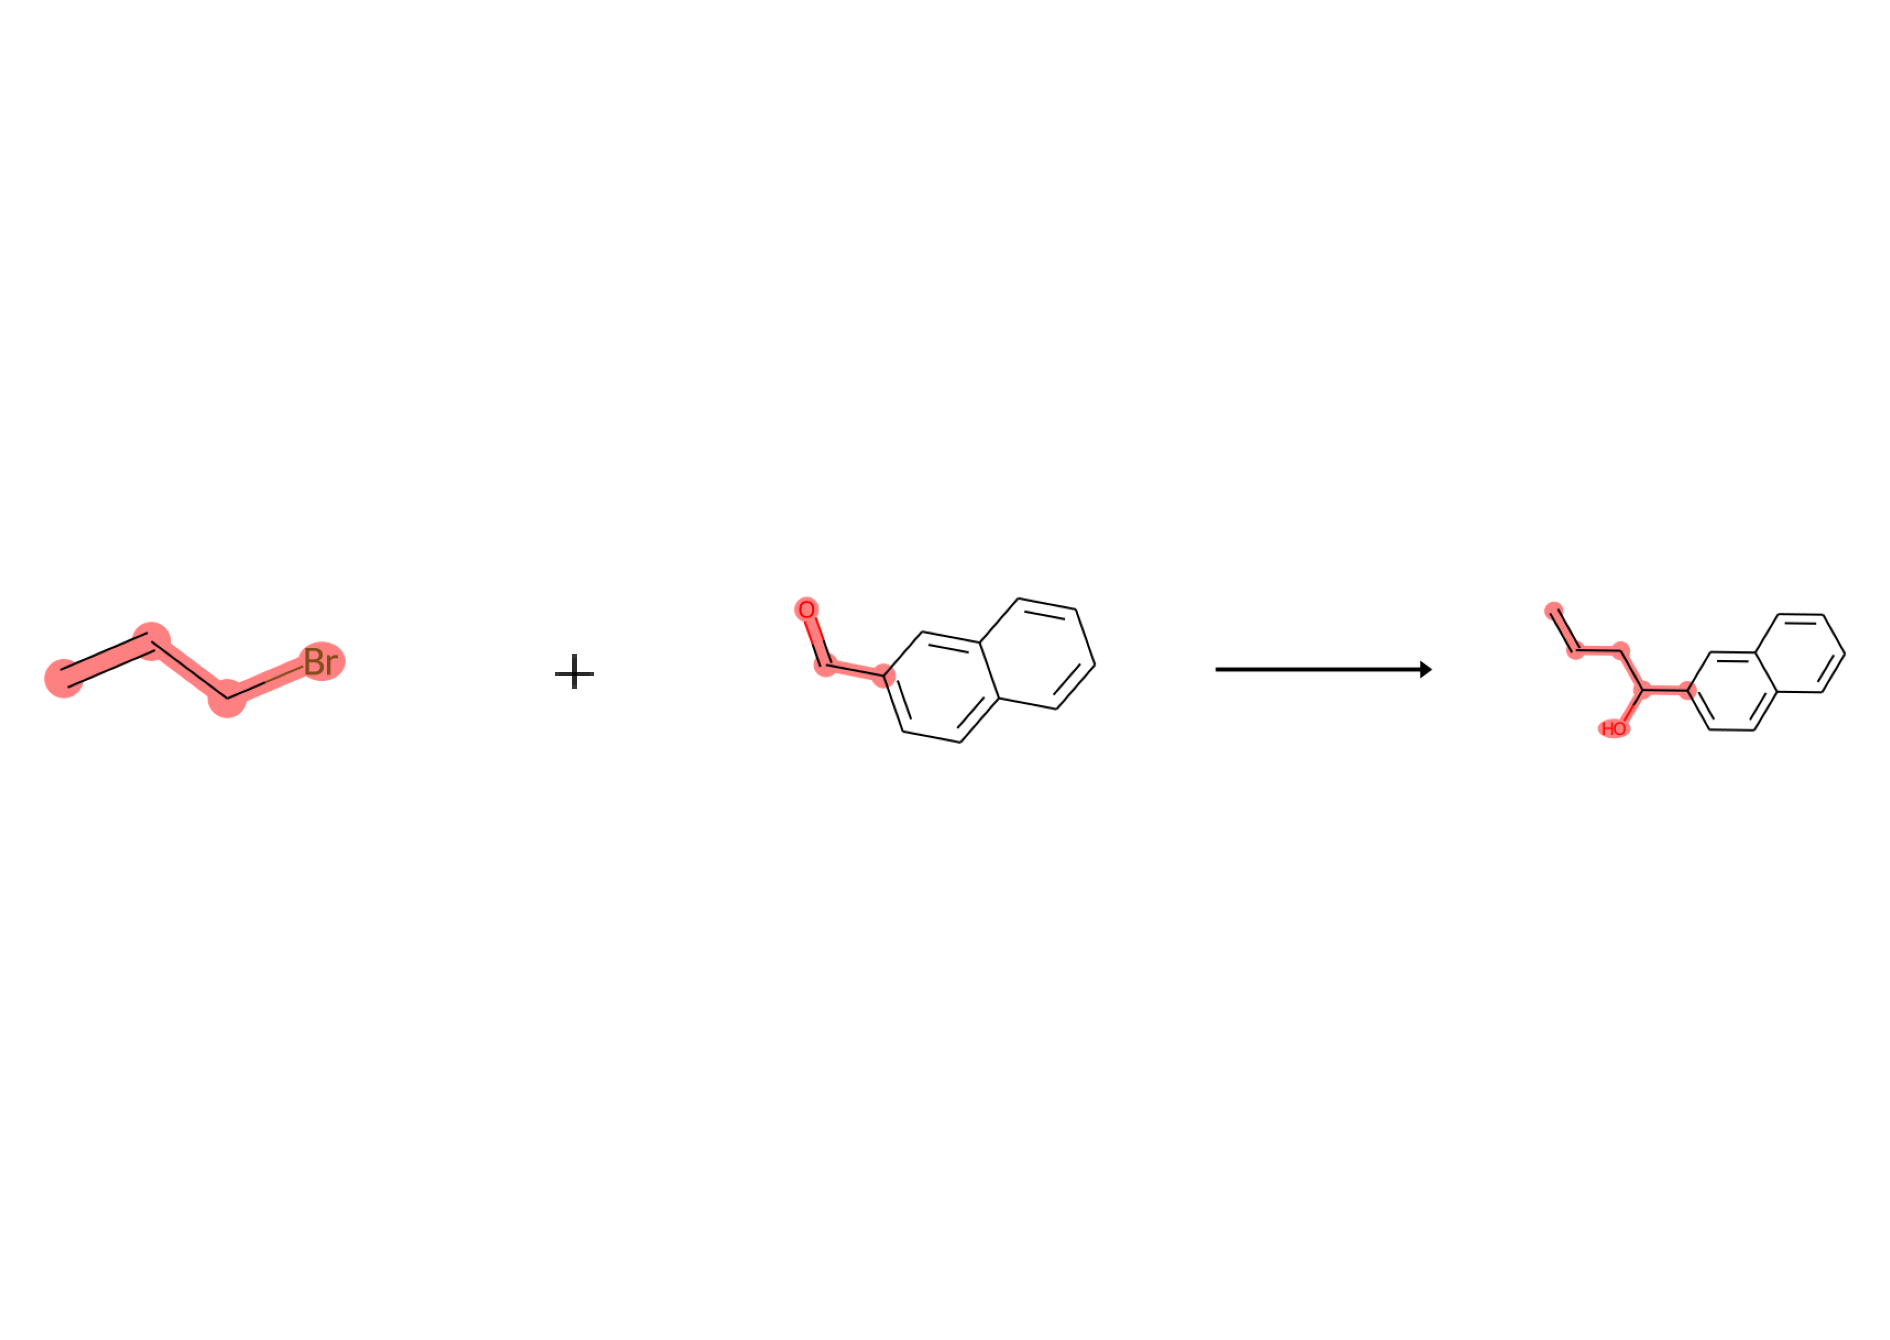

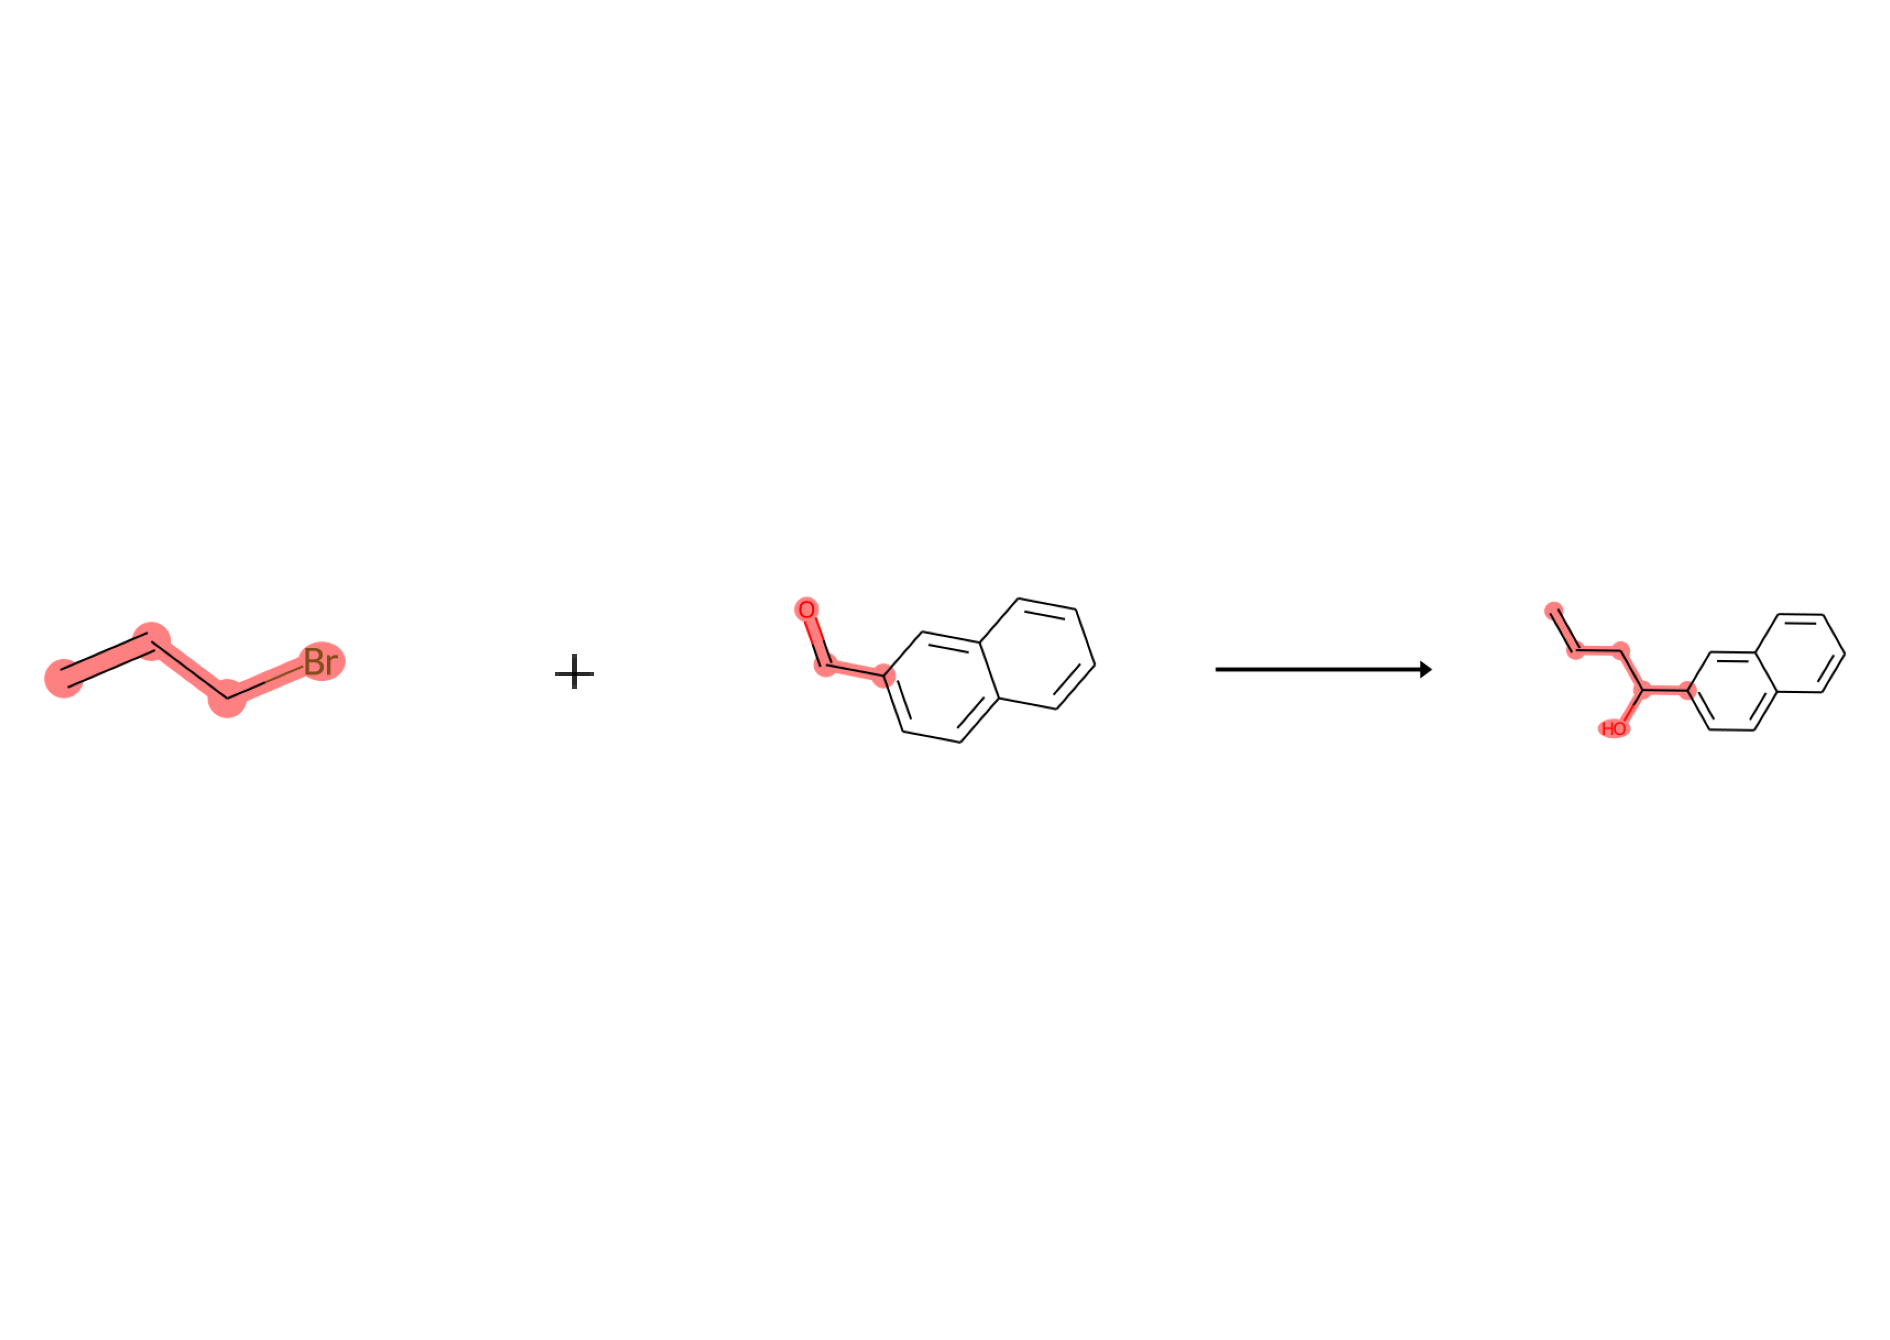

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.


['', 'CCOCC', '', '[Mg]', '']
torch.Size([3, 4, 46, 5])
46
['', 'CCOCC', '', 'II', '[Mg]']


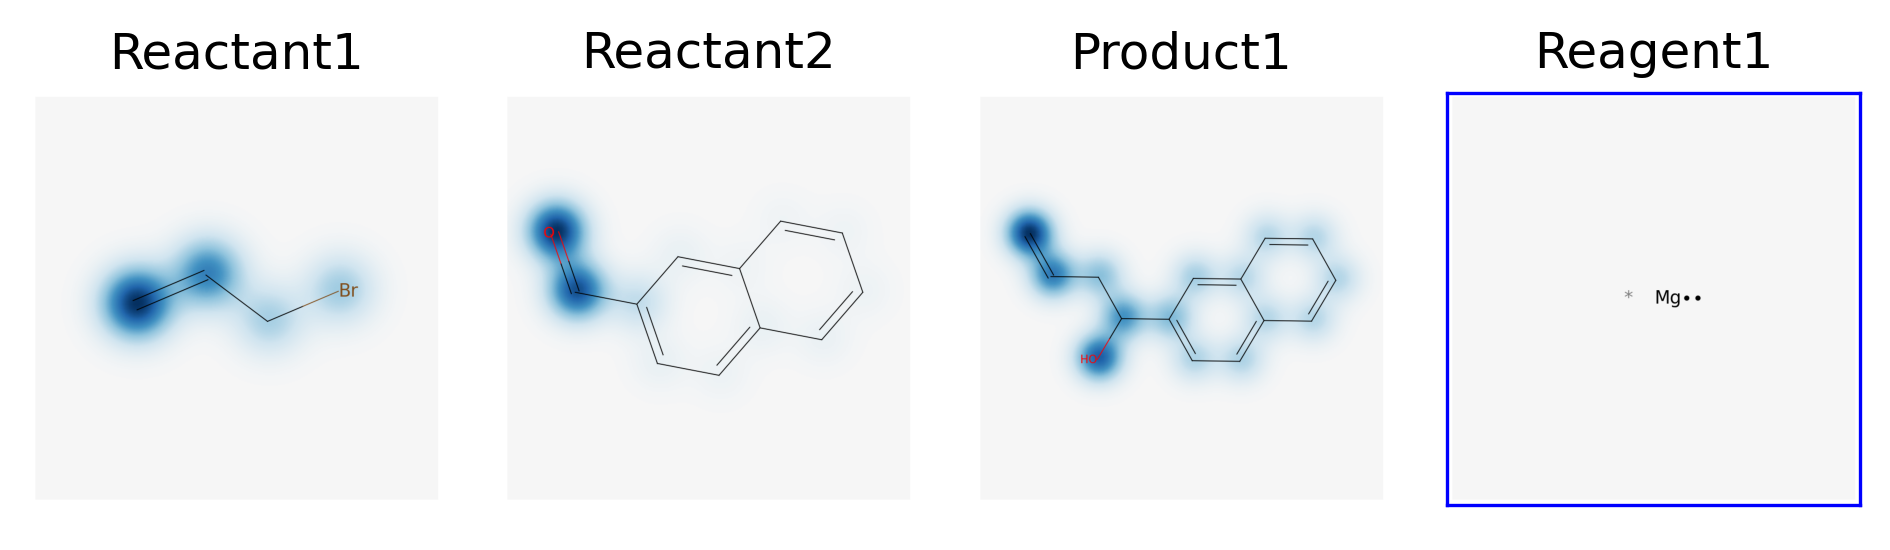

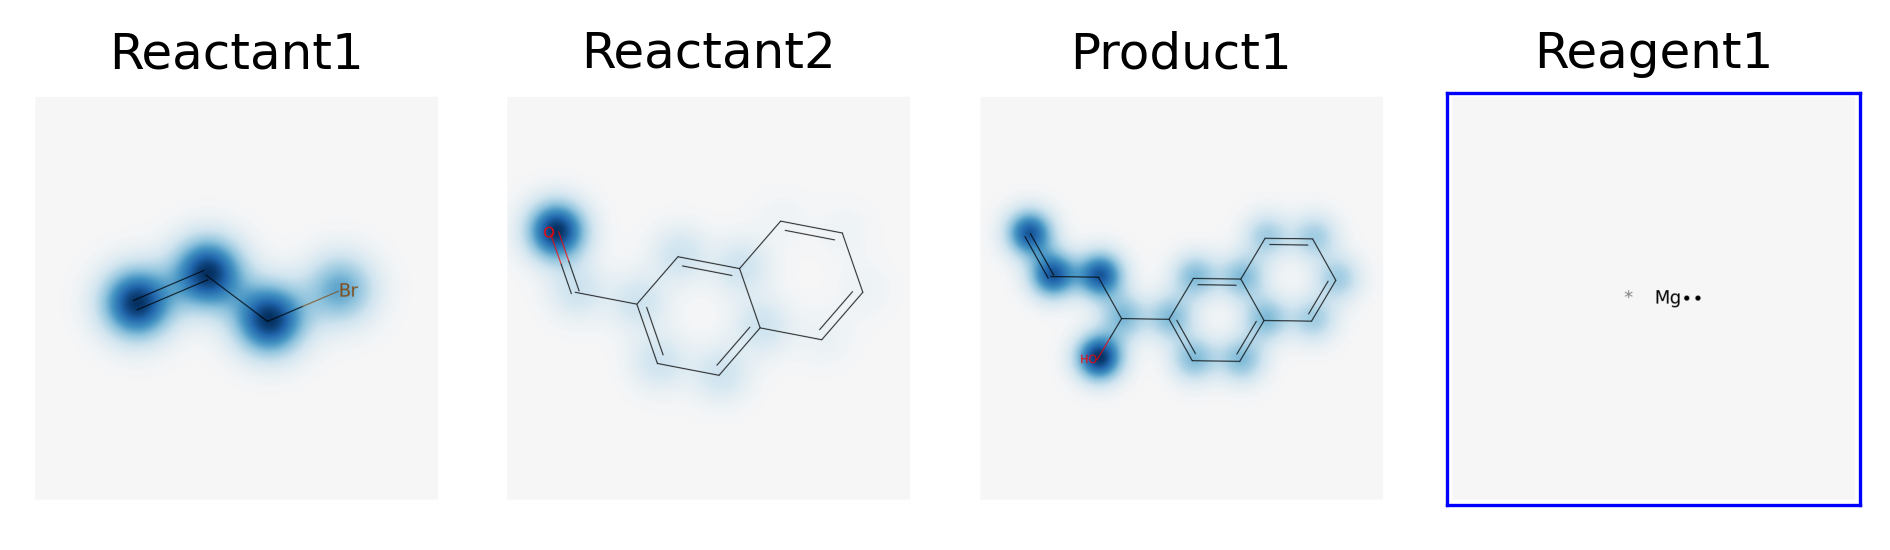

In [12]:
%matplotlib
idx = 63
rxn_smiles = input_df['canonical_rxn'].tolist()[idx]
gt_retro_template = input_df['retro_template'].tolist()[idx]
pred_retro_template = input_df['self_encoder_mapped_tpl'].tolist()[idx]
print(rxn_smiles)
print(gt_retro_template)
print(pred_retro_template)
show_rxn_with_highlight(rxn_smiles, gt_retro_template, pred_retro_template, save_path='attn_viz/test_rxn2rxn_{}_{}'.format(reaction_class.replace(' ', '_'), idx))
predicted_conditions, attention_weights, input_tokens = model.greedy_search_one_sample_with_attn(input_df['canonical_rxn'].tolist()[idx])
print(predicted_conditions)
print(attention_weights.shape)
print(len(input_tokens))
print(input_df['ground_truth_conditions'].tolist()[idx])

vis_attention_for_reaction(attention_weights, src_tokens=input_tokens, tgt_tokens=predicted_conditions, rxn_smiles=input_df['canonical_rxn'].tolist()[idx], output_fig_folder='attn_viz/test_rxn2condition_{}_{}'.format(reaction_class.replace(' ', '_'), idx))
vis_attention_for_reaction_mean_by_functional_group(attention_weights, src_tokens=input_tokens, tgt_tokens=predicted_conditions, rxn_smiles=input_df['canonical_rxn'].tolist()[idx], output_fig_folder='attn_viz/test_rxn2condition_{}_{}'.format(reaction_class.replace(' ', '_'), idx), functional_group_path='eval_data/group_attn_results/subgraph.csv')

In [13]:
reaction_class='ROH deprotections'
input_df, model = init_data_and_model(debug=True, input_path=save_path, reaction_class=reaction_class)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.

########################\Attention Evaluation configs:
########################

dataset_args:
  database_fname: USPTO_condition.csv
  dataset_root: dataset/source_dataset/USPTO_condition_final
  use_temperature: false
inference_args:
  beam:
    0: 2
    1: 3
    2: 1
    3: 3
    4: 1
model_args:
  best_model_dir: ./outputs/Parrot_train_in_USPTO_Condition_enhance
  decoder_args:
    d_model: 256
    dim_feedforward: 256
    dropout: 0.1
    nhead: 4
    num_decoder_layers: 3
    tgt_vocab_size: None
  evaluate_during_training: true
  fp16: false
  gradient_accumulation_steps: 1
  learning_rate: 0.0002
  manual_seed: 42
  max_seq_length: 512
  num_train_epochs: 100
  output_dir: ./out/Parrot_train_in_USPTO_Condition_enhance
  overwrite_output_dir: true
  pretrained_path: ./outputs/Parrot_train_in_USPTO_Condition
  regression: false
  thread_co

Using matplotlib backend: agg
Cc1cn(C[C@H]2CN(c3ccc(-c4ccc(C5=NOC(CO[Si](C)(C)C(C)(C)C)C5)cc4)cc3)C(=O)O2)nn1>>Cc1cn(C[C@H]2CN(c3ccc(-c4ccc(C5=NOC(CO)C5)cc4)cc3)C(=O)O2)nn1
[C:2]-[OH;D1;+0:1]>>C-C(-C)(-C)-[Si](-C)(-C)-[O;H0;D2;+0:1]-[C:2]
[C:2]-[OH;D1;+0:1]>>C-C(-C)(-C)-[Si](-C)(-C)-[O;H0;D2;+0:1]-[C:2]


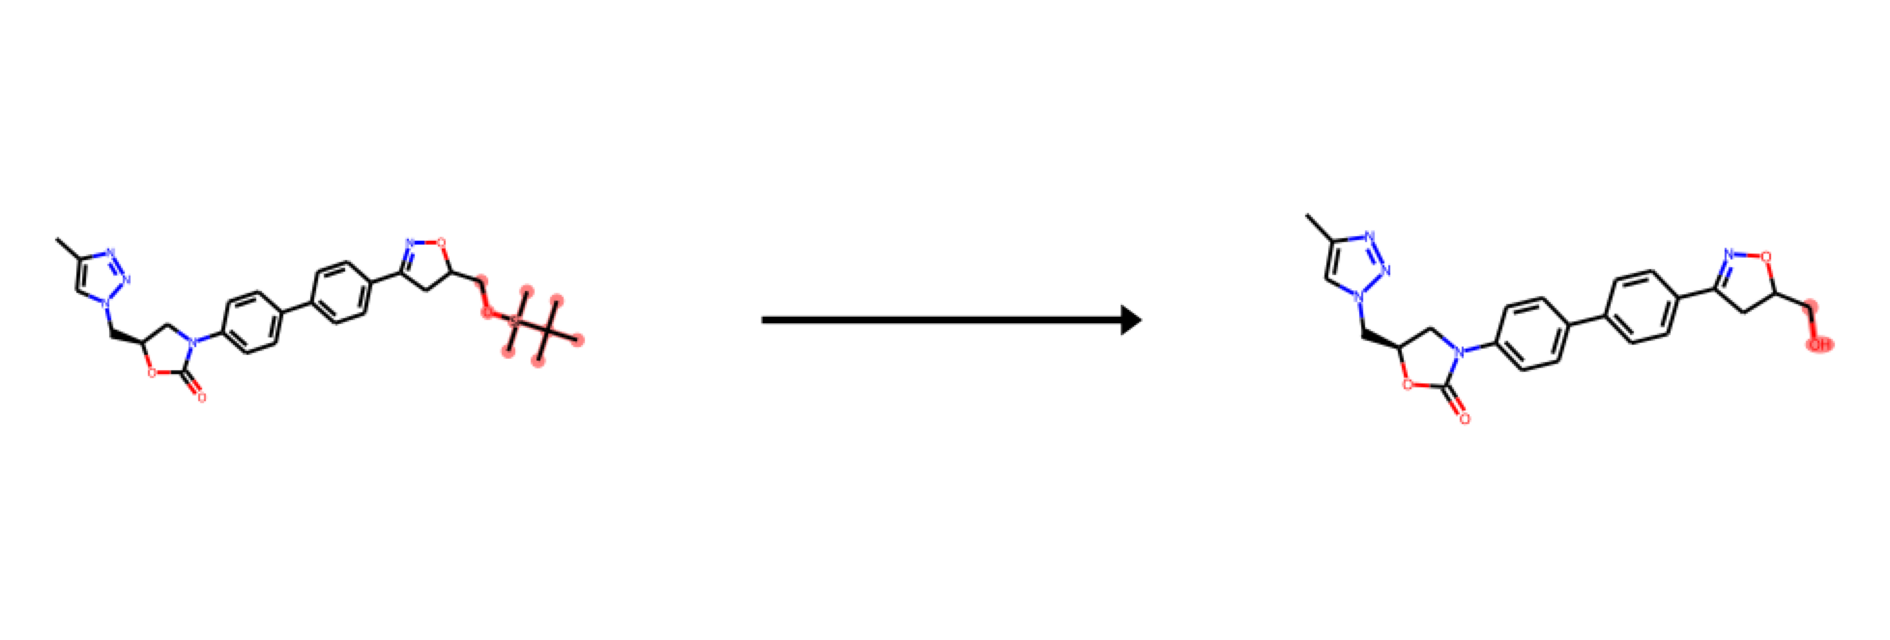

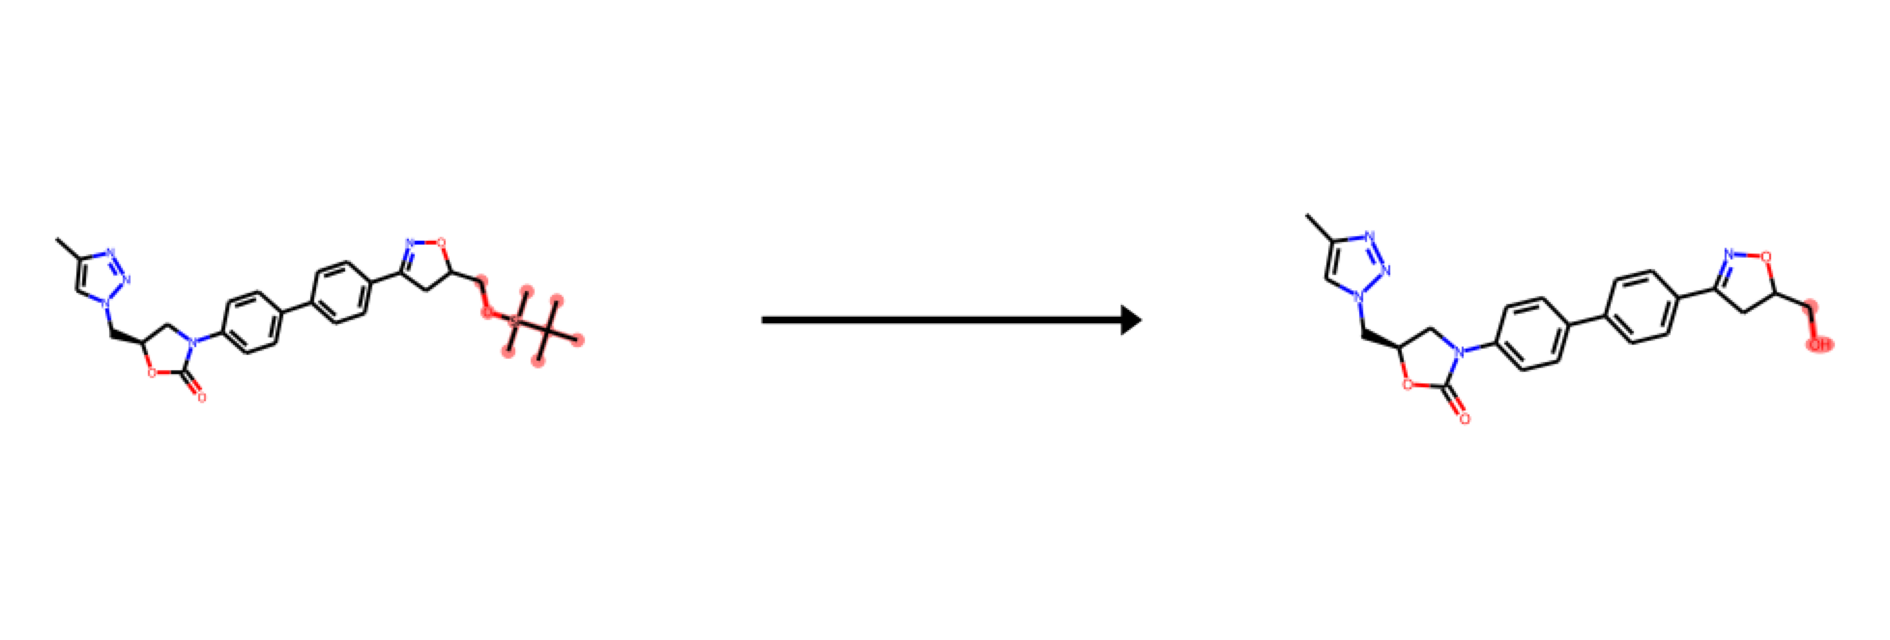

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.


['', 'C1CCOC1', '', 'CCCC[N+](CCCC)(CCCC)CCCC.[F-]', '']
torch.Size([3, 4, 130, 5])
130
['', 'C1CCOC1', 'CCOC(C)=O', 'O', 'CCCC[N+](CCCC)(CCCC)CCCC.[F-]']


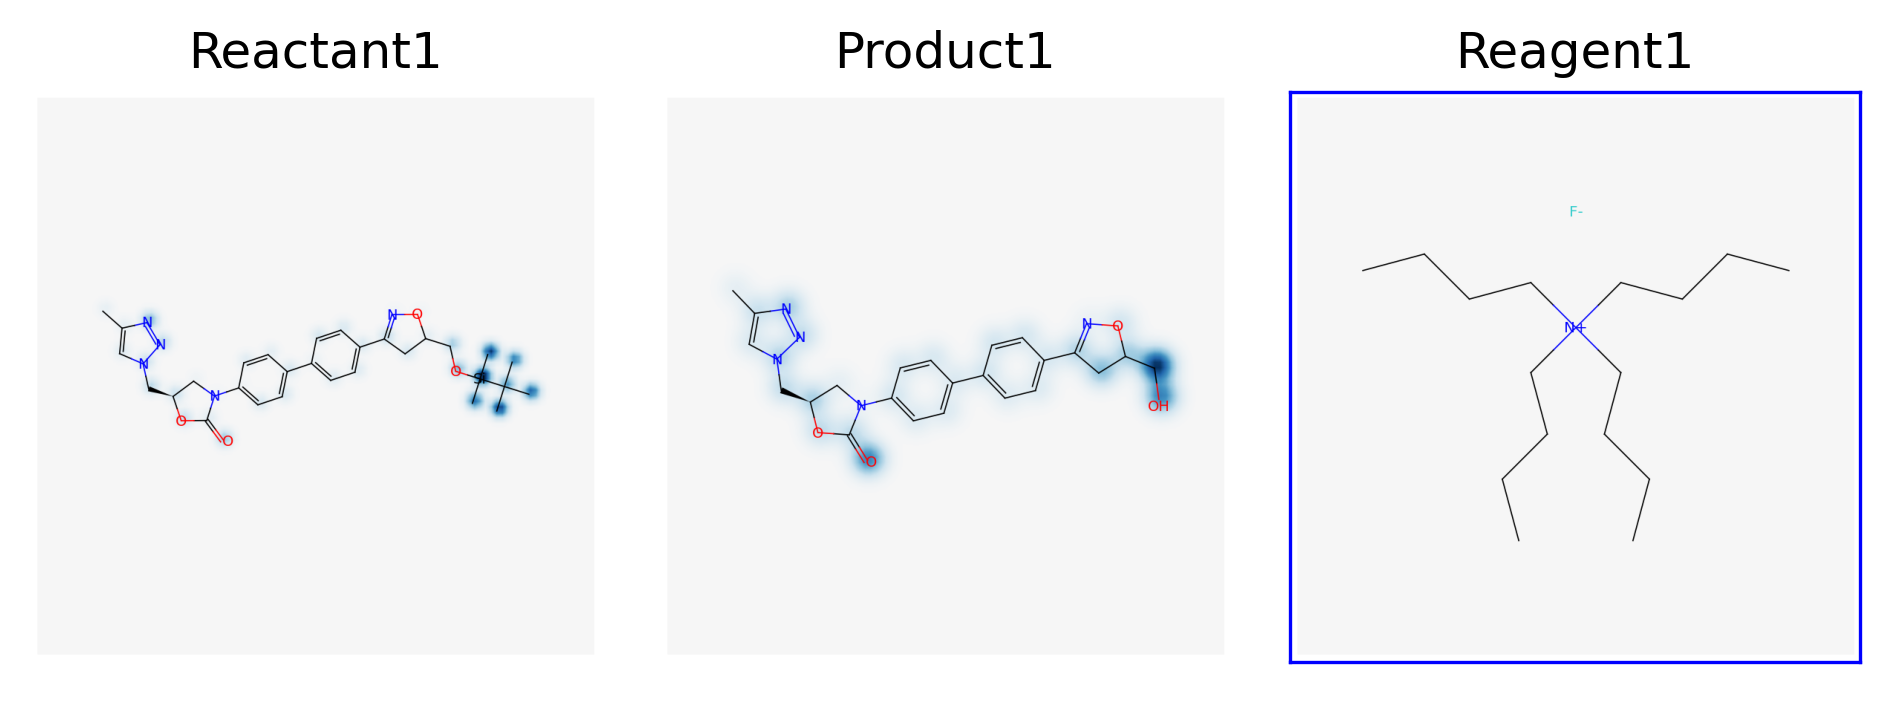

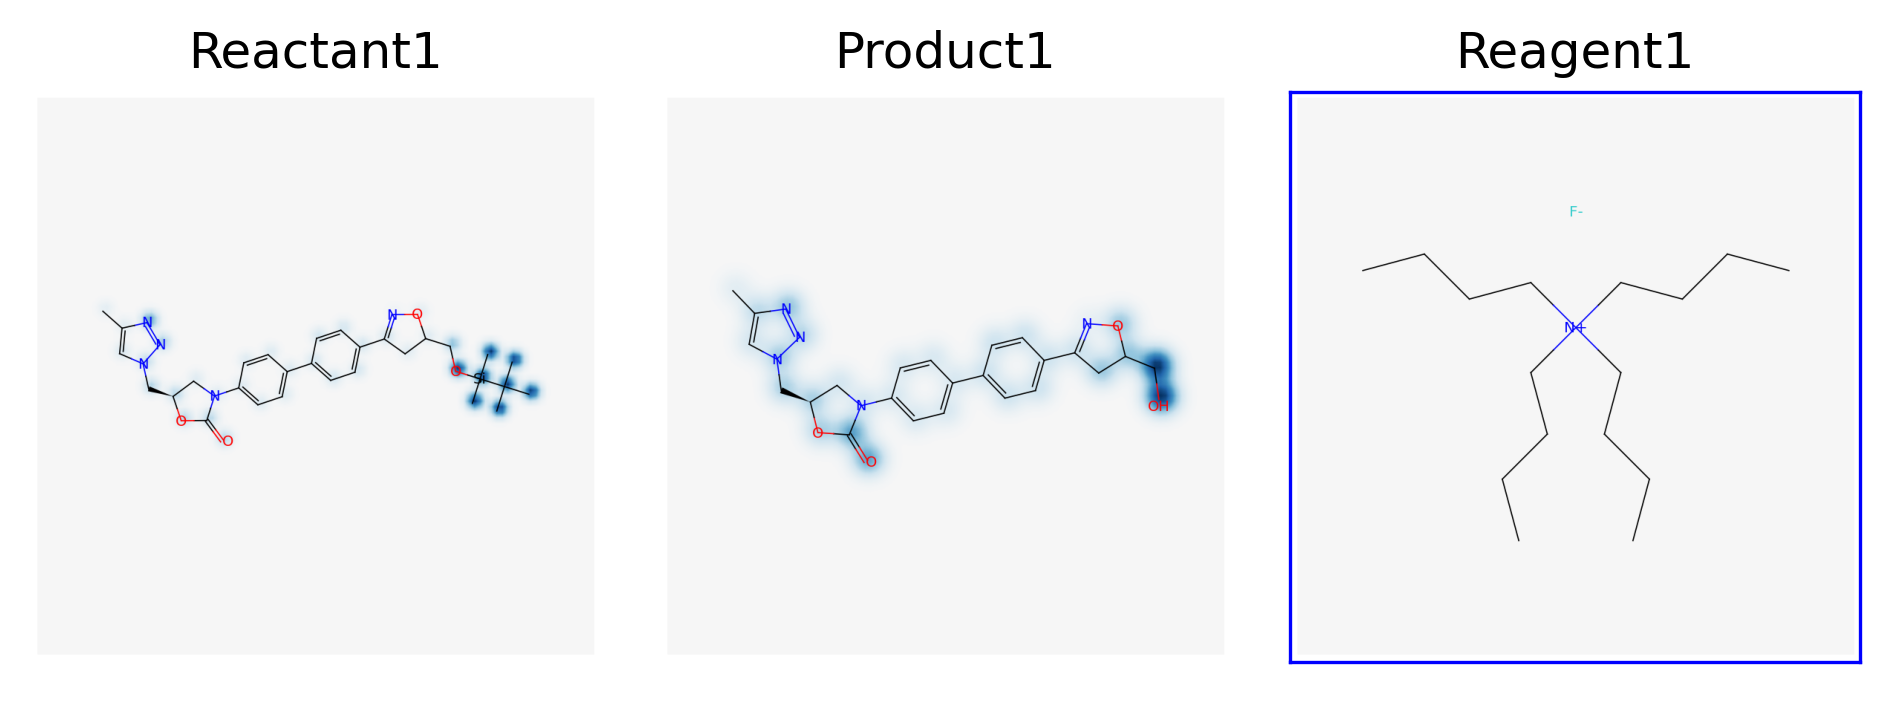

In [14]:
%matplotlib
idx = 63
rxn_smiles = input_df['canonical_rxn'].tolist()[idx]
gt_retro_template = input_df['retro_template'].tolist()[idx]
pred_retro_template = input_df['self_encoder_mapped_tpl'].tolist()[idx]
print(rxn_smiles)
print(gt_retro_template)
print(pred_retro_template)
show_rxn_with_highlight(rxn_smiles, gt_retro_template, pred_retro_template, save_path='attn_viz/test_rxn2rxn_{}_{}'.format(reaction_class.replace(' ', '_'), idx))
predicted_conditions, attention_weights, input_tokens = model.greedy_search_one_sample_with_attn(input_df['canonical_rxn'].tolist()[idx])
print(predicted_conditions)
print(attention_weights.shape)
print(len(input_tokens))
print(input_df['ground_truth_conditions'].tolist()[idx])

vis_attention_for_reaction(attention_weights, src_tokens=input_tokens, tgt_tokens=predicted_conditions, rxn_smiles=input_df['canonical_rxn'].tolist()[idx], output_fig_folder='attn_viz/test_rxn2condition_{}_{}'.format(reaction_class.replace(' ', '_'), idx))
vis_attention_for_reaction_mean_by_functional_group(attention_weights, src_tokens=input_tokens, tgt_tokens=predicted_conditions, rxn_smiles=input_df['canonical_rxn'].tolist()[idx], output_fig_folder='attn_viz/test_rxn2condition_{}_{}'.format(reaction_class.replace(' ', '_'), idx), functional_group_path='eval_data/group_attn_results/subgraph.csv')